In [19]:
import os
import gym
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
from tensorflow.keras import models, Model


## NN that represents the Actor and Critic

In [20]:
class ACNetwork(keras.Model):
    def __init__(self, n_actions, fc1_dims = 1024, fc2_dims = 512, 
                 name = "AC_network", chkpt_dir = "Actor_critic"):
        #create a directory with the same name as 'chkpt_dir' to store the weights of the model
    
    
        #Python has super function which allows us to access temporary object of the super class.
        #Use of super class is, we need not use the base class name explicitly and it also helps in working with 
        #multiple inheritance (main advantage).
        super(ACNetwork, self).__init__()
        
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        
        self.n_actions = n_actions
        self.model_name = name  #don't use name which is reserved for the base class
        
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name +'_ac')
        
        #no need to specify the input dimension because keras will infer that when a input is given
        self.fc1 = tf.keras.layers.Dense(self.fc1_dims, activation = 'relu', name = 'fc1')
        self.fc2 = tf.keras.layers.Dense(self.fc2_dims, activation = 'relu', name = 'fc2')
        
        #we use the same model architecture for both state values and the policy
        self.v = tf.keras.layers.Dense(1,activation = None, name='state_values')
        self.pi = tf.keras.layers.Dense(n_actions, activation = 'softmax', name = 'action_prob')
        
        
    def call(self, state):
        value = self.fc1(state)
        value = self.fc2(state)
        
        v = self.v(value)
        pi = self.pi(value)
        
        return v, pi
    
#     def build_graph(self):
#         x = tf.keras.layers.Input(shape = (None,4))
#         model = Model(inputs = x, outputs = self.call(x))
#         tf.keras.utils.plot_model(model, show_shapes = True, show_dtype = False, 
#                                   show_layer_names = True, rankdir = 'TB', expand_nested = True, dpi = 96)
        
#         return model

        

In [21]:
# #show the model architecture
# from keras.utils.vis_utils import plot_model

# acnetwork = ACNetwork(n_actions = 4)
# acnetwork.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02))
# acnetwork.build_graph().summary()


# # arnetwork()


### Actor Critic Algorithm 

In [22]:
class Agent:
    def __init__(self, alpha = 0.003, gamma = 0.99, n_actions = 2):
        self.gamma = gamma
#         self.alpha = alpha
        self.n_actions = n_actions
        
        self.action = None
        self.action_space = [i for i in range(self.n_actions)]
        #Build the actor_critic model
        self.actor_critic = ACNetwork(n_actions)
        self.actor_critic.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = alpha), loss = self.custom_loss)
        
    def choose_action(self, observation):
        state = tf.convert_to_tensor([observation]) #the extra [] is because NN takes input as a batch
        val, probs = self.actor_critic(state)
        
        #np.choices can also be used
        action_probabilities = tfp.distributions.Categorical(probs = probs)
        action = action_probabilities.sample() #sample of the distribution defined above
        log_prob = action_probabilities.log_prob(action)
        self.action = action
        
        #gym is only compatiable with numpy hence convert tensor to numpy value and [0] is because of additional
        #batch dimension we added in the 1st line of the function
        return action.numpy()[0] 
    
    def save_model(self):
        
        print('saving models.............')
        self.actor_critic.save_weights(self.actor_critic.checkpoint_file)
        
    def load_model(self):
        
        print('..........loding models')
        self.actor_critic.load_weights(self.actor_critic.checkpoint_file)
        
    
    def learn(self, state, reward, next_state, done):
        
        #just to be safe
        state = tf.convert_to_tensor([state], dtype = tf.float32)
        next_state = tf.convert_to_tensor([next_state], dtype = tf.float32)
        reward = tf.convert_to_tensor(reward, dtype = tf.float32)
        
        #Gradient tape is used to record ("tape") a sequence of operations performed upon some input and 
        #producing some output, so that the output can be differentiated with respect to the input
        with tf.GradientTape() as tape:
            
            #the gradient tape will dispose the operations/stored values after the calculation of gradients. 
            #By default, the resources held by GradientTape are released as soon as GradientTape.gradient() method 
            #is called. To compute multiple gradients over the same computation, create a persistent gradient tape. 
            #This allows multiple calls to the gradient() method as resources are released when the tape object is 
            #garbage collected. Use 'del tape' to delete it (should be done manually)
            
            #persistent = True is not required here. Required if separate actor and critic networks are used
            state_value, probs = self.actor_critic(state)
            nxtstate_value, no_probs = self.actor_critic(next_state)
            
            state_value = tf.squeeze(state_value) #to get rid of batch dimension (loss works well with 1D tensors)
            nxtstate_value = tf.squeeze(nxtstate_value)
            
            action_probabilities = tfp.distributions.Categorical(probs = probs)
            #calculate the log probability of the action we have taken
            log_probs = action_probabilities.log_prob(self.action) 
            
            TD_error = reward + self.gamma*nxtstate_value*(1.0-int(done)) -state_value
#             updated_state_value = state_value + 0.2*TD_error #check if this works
#             actor_loss = - TD_error * log_probs
#             critic_loss =  TD_error * TD_error
            
#             #why are we trying to minimize the the total loss instead of individual loss. Check if
#             #individual loss with different architecture for actor and critic networks works well.
#             total_loss = actor_loss + critic_loss

            total_loss = self.custom_loss(TD_error, log_probs)
        gradients = tape.gradient(total_loss, self.actor_critic.trainable_variables)
        self.actor_critic.optimizer.apply_gradients([(grad,var) for (grad,var) in zip(gradients, self.actor_critic.trainable_variables) if grad is not None])
        
    def custom_loss(self, TD_error, log_probs ):
        actor_loss =  - TD_error * log_probs
        critic_loss = TD_error**2 #else use Huber loss

        #why are we trying to minimize the the total loss instead of individual loss. Check if
        #individual loss with different architecture for actor and critic networks works well.
        total_loss = actor_loss + critic_loss
        
        return total_loss

        

### Play the agent for pre-specified number of games

In [27]:
# import warnings; warnings.simplefilter('ignore')

env = gym.make('CartPole-v1')
# print(env.action_space.__doc__)
agent = Agent(alpha = 1e-5, n_actions = env.action_space.n) #instantiate the agent

n_games = 18000

figure_file = 'plots/cartpole.png'

best_score = env.reward_range[0] #lowest possible reward
print(env.reward_range)

score_history = [] #empty list to store the returns
load_checkpoint = False # True : if we have a pre-trained model

if load_checkpoint:
    agent.load_model()
    
for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    while not done:
        action = agent.choose_action(observation)
        next_observation, reward, done, info = env.step(action)
        score += reward
        
        if not load_checkpoint:
            agent.learn(observation, reward, next_observation, done)
        observation = next_observation
        
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
    
    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_model() #repalces the already saved model with best weights 
        
    print("Episode : ",i, ' score: %.1f' %score, ' avg_score: %.1f' %avg_score)
    
        

(-inf, inf)
saving models.............
Episode :  0  score: 16.0  avg_score: 16.0
Episode :  1  score: 15.0  avg_score: 15.5
Episode :  2  score: 12.0  avg_score: 14.3
saving models.............
Episode :  3  score: 23.0  avg_score: 16.5
saving models.............
Episode :  4  score: 23.0  avg_score: 17.8
Episode :  5  score: 15.0  avg_score: 17.3
Episode :  6  score: 12.0  avg_score: 16.6
Episode :  7  score: 16.0  avg_score: 16.5
Episode :  8  score: 28.0  avg_score: 17.8
Episode :  9  score: 11.0  avg_score: 17.1
Episode :  10  score: 12.0  avg_score: 16.6
saving models.............
Episode :  11  score: 33.0  avg_score: 18.0
Episode :  12  score: 14.0  avg_score: 17.7
Episode :  13  score: 19.0  avg_score: 17.8
Episode :  14  score: 17.0  avg_score: 17.7
saving models.............
Episode :  15  score: 27.0  avg_score: 18.3
Episode :  16  score: 15.0  avg_score: 18.1
Episode :  17  score: 15.0  avg_score: 17.9
Episode :  18  score: 13.0  avg_score: 17.7
saving models.............


Episode :  164  score: 20.0  avg_score: 23.4
Episode :  165  score: 14.0  avg_score: 23.3
Episode :  166  score: 17.0  avg_score: 23.2
Episode :  167  score: 25.0  avg_score: 23.1
Episode :  168  score: 16.0  avg_score: 22.9
Episode :  169  score: 12.0  avg_score: 22.9
Episode :  170  score: 12.0  avg_score: 22.9
Episode :  171  score: 14.0  avg_score: 22.8
Episode :  172  score: 16.0  avg_score: 22.8
Episode :  173  score: 11.0  avg_score: 22.8
Episode :  174  score: 13.0  avg_score: 22.7
Episode :  175  score: 15.0  avg_score: 22.8
Episode :  176  score: 24.0  avg_score: 22.9
Episode :  177  score: 10.0  avg_score: 22.4
Episode :  178  score: 12.0  avg_score: 21.9
Episode :  179  score: 39.0  avg_score: 21.9
Episode :  180  score: 22.0  avg_score: 22.0
Episode :  181  score: 21.0  avg_score: 22.1
Episode :  182  score: 13.0  avg_score: 22.1
Episode :  183  score: 13.0  avg_score: 21.9
Episode :  184  score: 14.0  avg_score: 21.9
Episode :  185  score: 42.0  avg_score: 21.7
Episode : 

Episode :  348  score: 27.0  avg_score: 22.2
Episode :  349  score: 14.0  avg_score: 22.2
Episode :  350  score: 42.0  avg_score: 22.3
Episode :  351  score: 13.0  avg_score: 22.3
Episode :  352  score: 12.0  avg_score: 22.2
Episode :  353  score: 18.0  avg_score: 21.9
Episode :  354  score: 24.0  avg_score: 22.0
Episode :  355  score: 35.0  avg_score: 22.2
Episode :  356  score: 11.0  avg_score: 22.2
Episode :  357  score: 37.0  avg_score: 21.8
Episode :  358  score: 44.0  avg_score: 22.1
Episode :  359  score: 25.0  avg_score: 22.2
Episode :  360  score: 28.0  avg_score: 22.2
Episode :  361  score: 23.0  avg_score: 22.1
Episode :  362  score: 20.0  avg_score: 22.2
Episode :  363  score: 42.0  avg_score: 22.5
Episode :  364  score: 37.0  avg_score: 22.7
Episode :  365  score: 16.0  avg_score: 22.7
Episode :  366  score: 39.0  avg_score: 23.0
Episode :  367  score: 21.0  avg_score: 23.0
Episode :  368  score: 9.0  avg_score: 22.9
Episode :  369  score: 22.0  avg_score: 22.9
Episode :  

Episode :  531  score: 15.0  avg_score: 21.4
Episode :  532  score: 15.0  avg_score: 21.2
Episode :  533  score: 28.0  avg_score: 21.1
Episode :  534  score: 66.0  avg_score: 21.6
Episode :  535  score: 18.0  avg_score: 21.6
Episode :  536  score: 12.0  avg_score: 21.6
Episode :  537  score: 29.0  avg_score: 21.7
Episode :  538  score: 28.0  avg_score: 21.7
Episode :  539  score: 16.0  avg_score: 21.6
Episode :  540  score: 20.0  avg_score: 21.4
Episode :  541  score: 22.0  avg_score: 21.4
Episode :  542  score: 15.0  avg_score: 20.9
Episode :  543  score: 23.0  avg_score: 21.1
Episode :  544  score: 11.0  avg_score: 20.8
Episode :  545  score: 15.0  avg_score: 20.8
Episode :  546  score: 15.0  avg_score: 20.8
Episode :  547  score: 12.0  avg_score: 20.4
Episode :  548  score: 13.0  avg_score: 20.2
Episode :  549  score: 21.0  avg_score: 20.3
Episode :  550  score: 20.0  avg_score: 20.4
Episode :  551  score: 12.0  avg_score: 20.4
Episode :  552  score: 14.0  avg_score: 20.4
Episode : 

Episode :  714  score: 16.0  avg_score: 22.0
Episode :  715  score: 11.0  avg_score: 21.8
Episode :  716  score: 12.0  avg_score: 21.7
Episode :  717  score: 20.0  avg_score: 21.5
Episode :  718  score: 20.0  avg_score: 21.5
Episode :  719  score: 13.0  avg_score: 21.6
Episode :  720  score: 22.0  avg_score: 21.4
Episode :  721  score: 17.0  avg_score: 21.2
Episode :  722  score: 13.0  avg_score: 21.1
Episode :  723  score: 19.0  avg_score: 21.1
Episode :  724  score: 26.0  avg_score: 21.2
Episode :  725  score: 19.0  avg_score: 21.3
Episode :  726  score: 27.0  avg_score: 21.4
Episode :  727  score: 13.0  avg_score: 21.4
Episode :  728  score: 10.0  avg_score: 21.2
Episode :  729  score: 33.0  avg_score: 21.2
Episode :  730  score: 8.0  avg_score: 21.1
Episode :  731  score: 10.0  avg_score: 20.5
Episode :  732  score: 22.0  avg_score: 20.5
Episode :  733  score: 19.0  avg_score: 20.4
Episode :  734  score: 11.0  avg_score: 20.3
Episode :  735  score: 37.0  avg_score: 20.5
Episode :  

Episode :  897  score: 16.0  avg_score: 22.6
Episode :  898  score: 37.0  avg_score: 22.7
Episode :  899  score: 20.0  avg_score: 22.6
Episode :  900  score: 28.0  avg_score: 22.7
Episode :  901  score: 15.0  avg_score: 22.6
Episode :  902  score: 20.0  avg_score: 22.7
Episode :  903  score: 21.0  avg_score: 22.6
Episode :  904  score: 21.0  avg_score: 22.7
Episode :  905  score: 23.0  avg_score: 22.8
Episode :  906  score: 15.0  avg_score: 22.7
Episode :  907  score: 22.0  avg_score: 22.7
Episode :  908  score: 21.0  avg_score: 22.3
Episode :  909  score: 44.0  avg_score: 22.6
Episode :  910  score: 11.0  avg_score: 22.3
Episode :  911  score: 20.0  avg_score: 22.3
Episode :  912  score: 14.0  avg_score: 22.2
Episode :  913  score: 12.0  avg_score: 22.0
Episode :  914  score: 11.0  avg_score: 22.0
Episode :  915  score: 10.0  avg_score: 21.8
Episode :  916  score: 15.0  avg_score: 21.8
Episode :  917  score: 18.0  avg_score: 21.9
Episode :  918  score: 37.0  avg_score: 21.8
Episode : 

Episode :  1079  score: 34.0  avg_score: 21.5
Episode :  1080  score: 13.0  avg_score: 21.5
Episode :  1081  score: 17.0  avg_score: 21.5
Episode :  1082  score: 28.0  avg_score: 21.6
Episode :  1083  score: 11.0  avg_score: 21.6
Episode :  1084  score: 33.0  avg_score: 21.8
Episode :  1085  score: 23.0  avg_score: 21.8
Episode :  1086  score: 41.0  avg_score: 22.1
Episode :  1087  score: 30.0  avg_score: 22.3
Episode :  1088  score: 12.0  avg_score: 22.3
Episode :  1089  score: 31.0  avg_score: 22.3
Episode :  1090  score: 13.0  avg_score: 22.1
Episode :  1091  score: 22.0  avg_score: 22.1
Episode :  1092  score: 26.0  avg_score: 22.2
Episode :  1093  score: 36.0  avg_score: 22.4
Episode :  1094  score: 14.0  avg_score: 22.4
Episode :  1095  score: 13.0  avg_score: 22.2
Episode :  1096  score: 30.0  avg_score: 22.4
Episode :  1097  score: 24.0  avg_score: 22.4
Episode :  1098  score: 16.0  avg_score: 22.3
Episode :  1099  score: 24.0  avg_score: 22.4
Episode :  1100  score: 91.0  avg_

Episode :  1258  score: 38.0  avg_score: 23.6
Episode :  1259  score: 20.0  avg_score: 23.6
Episode :  1260  score: 9.0  avg_score: 23.5
Episode :  1261  score: 25.0  avg_score: 23.2
Episode :  1262  score: 17.0  avg_score: 23.1
Episode :  1263  score: 21.0  avg_score: 23.2
Episode :  1264  score: 20.0  avg_score: 23.2
Episode :  1265  score: 42.0  avg_score: 23.4
Episode :  1266  score: 19.0  avg_score: 23.4
Episode :  1267  score: 17.0  avg_score: 23.4
Episode :  1268  score: 20.0  avg_score: 23.4
Episode :  1269  score: 13.0  avg_score: 23.2
Episode :  1270  score: 26.0  avg_score: 23.4
Episode :  1271  score: 22.0  avg_score: 23.4
Episode :  1272  score: 12.0  avg_score: 23.3
Episode :  1273  score: 45.0  avg_score: 23.1
Episode :  1274  score: 12.0  avg_score: 23.0
Episode :  1275  score: 19.0  avg_score: 23.0
Episode :  1276  score: 15.0  avg_score: 23.1
Episode :  1277  score: 33.0  avg_score: 23.2
Episode :  1278  score: 23.0  avg_score: 23.2
Episode :  1279  score: 32.0  avg_s

Episode :  1436  score: 38.0  avg_score: 20.9
Episode :  1437  score: 36.0  avg_score: 21.1
Episode :  1438  score: 11.0  avg_score: 20.9
Episode :  1439  score: 15.0  avg_score: 20.9
Episode :  1440  score: 18.0  avg_score: 20.9
Episode :  1441  score: 16.0  avg_score: 20.8
Episode :  1442  score: 18.0  avg_score: 20.7
Episode :  1443  score: 24.0  avg_score: 20.7
Episode :  1444  score: 16.0  avg_score: 20.7
Episode :  1445  score: 74.0  avg_score: 20.9
Episode :  1446  score: 16.0  avg_score: 20.9
Episode :  1447  score: 29.0  avg_score: 21.0
Episode :  1448  score: 23.0  avg_score: 21.1
Episode :  1449  score: 22.0  avg_score: 21.0
Episode :  1450  score: 44.0  avg_score: 21.3
Episode :  1451  score: 17.0  avg_score: 21.1
Episode :  1452  score: 23.0  avg_score: 21.2
Episode :  1453  score: 17.0  avg_score: 21.3
Episode :  1454  score: 18.0  avg_score: 21.3
Episode :  1455  score: 10.0  avg_score: 21.2
Episode :  1456  score: 22.0  avg_score: 21.1
Episode :  1457  score: 21.0  avg_

Episode :  1617  score: 13.0  avg_score: 20.7
Episode :  1618  score: 17.0  avg_score: 20.7
Episode :  1619  score: 15.0  avg_score: 20.7
Episode :  1620  score: 20.0  avg_score: 20.7
Episode :  1621  score: 30.0  avg_score: 20.9
Episode :  1622  score: 40.0  avg_score: 21.2
Episode :  1623  score: 16.0  avg_score: 21.1
Episode :  1624  score: 14.0  avg_score: 21.0
Episode :  1625  score: 48.0  avg_score: 21.3
Episode :  1626  score: 33.0  avg_score: 21.4
Episode :  1627  score: 22.0  avg_score: 21.3
Episode :  1628  score: 12.0  avg_score: 21.2
Episode :  1629  score: 21.0  avg_score: 21.0
Episode :  1630  score: 14.0  avg_score: 21.0
Episode :  1631  score: 16.0  avg_score: 21.0
Episode :  1632  score: 21.0  avg_score: 21.0
Episode :  1633  score: 40.0  avg_score: 21.4
Episode :  1634  score: 15.0  avg_score: 21.3
Episode :  1635  score: 25.0  avg_score: 21.2
Episode :  1636  score: 15.0  avg_score: 21.2
Episode :  1637  score: 11.0  avg_score: 21.1
Episode :  1638  score: 42.0  avg_

Episode :  1797  score: 14.0  avg_score: 22.6
Episode :  1798  score: 20.0  avg_score: 22.6
Episode :  1799  score: 12.0  avg_score: 22.7
Episode :  1800  score: 41.0  avg_score: 22.9
Episode :  1801  score: 53.0  avg_score: 23.1
Episode :  1802  score: 40.0  avg_score: 23.3
Episode :  1803  score: 14.0  avg_score: 23.4
Episode :  1804  score: 36.0  avg_score: 23.6
Episode :  1805  score: 11.0  avg_score: 23.4
Episode :  1806  score: 16.0  avg_score: 23.3
Episode :  1807  score: 16.0  avg_score: 23.0
Episode :  1808  score: 42.0  avg_score: 23.2
Episode :  1809  score: 13.0  avg_score: 22.9
Episode :  1810  score: 25.0  avg_score: 23.0
Episode :  1811  score: 21.0  avg_score: 22.6
Episode :  1812  score: 22.0  avg_score: 22.7
Episode :  1813  score: 57.0  avg_score: 23.0
Episode :  1814  score: 12.0  avg_score: 22.8
Episode :  1815  score: 23.0  avg_score: 22.2
Episode :  1816  score: 42.0  avg_score: 22.4
Episode :  1817  score: 33.0  avg_score: 22.6
Episode :  1818  score: 21.0  avg_

Episode :  1964  score: 38.0  avg_score: 27.9
Episode :  1965  score: 28.0  avg_score: 28.0
Episode :  1966  score: 25.0  avg_score: 28.0
Episode :  1967  score: 12.0  avg_score: 27.9
Episode :  1968  score: 13.0  avg_score: 27.8
Episode :  1969  score: 17.0  avg_score: 27.7
Episode :  1970  score: 11.0  avg_score: 27.6
Episode :  1971  score: 29.0  avg_score: 27.7
Episode :  1972  score: 10.0  avg_score: 27.6
Episode :  1973  score: 29.0  avg_score: 27.7
Episode :  1974  score: 19.0  avg_score: 27.7
Episode :  1975  score: 32.0  avg_score: 27.4
Episode :  1976  score: 9.0  avg_score: 27.4
Episode :  1977  score: 14.0  avg_score: 27.3
Episode :  1978  score: 34.0  avg_score: 27.4
Episode :  1979  score: 19.0  avg_score: 27.4
Episode :  1980  score: 13.0  avg_score: 27.4
Episode :  1981  score: 19.0  avg_score: 27.5
Episode :  1982  score: 30.0  avg_score: 27.6
Episode :  1983  score: 13.0  avg_score: 27.4
Episode :  1984  score: 17.0  avg_score: 27.4
Episode :  1985  score: 21.0  avg_s

Episode :  2143  score: 37.0  avg_score: 25.2
Episode :  2144  score: 10.0  avg_score: 24.8
Episode :  2145  score: 20.0  avg_score: 24.7
Episode :  2146  score: 24.0  avg_score: 24.8
Episode :  2147  score: 38.0  avg_score: 25.0
Episode :  2148  score: 17.0  avg_score: 24.8
Episode :  2149  score: 40.0  avg_score: 25.1
Episode :  2150  score: 24.0  avg_score: 24.9
Episode :  2151  score: 23.0  avg_score: 25.0
Episode :  2152  score: 23.0  avg_score: 25.0
Episode :  2153  score: 26.0  avg_score: 25.2
Episode :  2154  score: 16.0  avg_score: 25.2
Episode :  2155  score: 26.0  avg_score: 25.0
Episode :  2156  score: 19.0  avg_score: 25.0
Episode :  2157  score: 43.0  avg_score: 25.3
Episode :  2158  score: 84.0  avg_score: 25.9
Episode :  2159  score: 19.0  avg_score: 25.9
Episode :  2160  score: 14.0  avg_score: 25.9
Episode :  2161  score: 12.0  avg_score: 25.7
Episode :  2162  score: 16.0  avg_score: 25.6
Episode :  2163  score: 27.0  avg_score: 25.4
Episode :  2164  score: 35.0  avg_

saving models.............
Episode :  2316  score: 19.0  avg_score: 29.6
Episode :  2317  score: 12.0  avg_score: 29.5
Episode :  2318  score: 22.0  avg_score: 29.5
Episode :  2319  score: 13.0  avg_score: 29.5
Episode :  2320  score: 26.0  avg_score: 29.6
saving models.............
Episode :  2321  score: 28.0  avg_score: 29.7
saving models.............
Episode :  2322  score: 38.0  avg_score: 29.8
saving models.............
Episode :  2323  score: 27.0  avg_score: 29.9
Episode :  2324  score: 21.0  avg_score: 29.9
saving models.............
Episode :  2325  score: 90.0  avg_score: 30.6
saving models.............
Episode :  2326  score: 30.0  avg_score: 30.8
Episode :  2327  score: 11.0  avg_score: 30.3
Episode :  2328  score: 33.0  avg_score: 30.5
Episode :  2329  score: 13.0  avg_score: 30.5
Episode :  2330  score: 12.0  avg_score: 30.3
Episode :  2331  score: 34.0  avg_score: 30.5
Episode :  2332  score: 22.0  avg_score: 30.6
Episode :  2333  score: 21.0  avg_score: 30.5
Episode : 

Episode :  2483  score: 29.0  avg_score: 32.8
Episode :  2484  score: 19.0  avg_score: 32.5
Episode :  2485  score: 20.0  avg_score: 32.5
Episode :  2486  score: 33.0  avg_score: 32.2
Episode :  2487  score: 24.0  avg_score: 32.3
Episode :  2488  score: 38.0  avg_score: 32.5
Episode :  2489  score: 20.0  avg_score: 32.4
Episode :  2490  score: 71.0  avg_score: 33.0
Episode :  2491  score: 30.0  avg_score: 33.1
Episode :  2492  score: 20.0  avg_score: 32.8
Episode :  2493  score: 23.0  avg_score: 32.9
saving models.............
Episode :  2494  score: 120.0  avg_score: 33.6
saving models.............
Episode :  2495  score: 20.0  avg_score: 33.6
Episode :  2496  score: 28.0  avg_score: 33.4
Episode :  2497  score: 18.0  avg_score: 33.3
Episode :  2498  score: 23.0  avg_score: 33.3
Episode :  2499  score: 52.0  avg_score: 33.3
Episode :  2500  score: 22.0  avg_score: 33.4
Episode :  2501  score: 47.0  avg_score: 33.4
Episode :  2502  score: 23.0  avg_score: 33.4
Episode :  2503  score: 1

saving models.............
Episode :  2649  score: 41.0  avg_score: 38.6
Episode :  2650  score: 39.0  avg_score: 38.6
Episode :  2651  score: 33.0  avg_score: 38.1
Episode :  2652  score: 54.0  avg_score: 38.0
Episode :  2653  score: 43.0  avg_score: 38.2
saving models.............
Episode :  2654  score: 102.0  avg_score: 39.0
Episode :  2655  score: 24.0  avg_score: 39.0
Episode :  2656  score: 31.0  avg_score: 39.0
saving models.............
Episode :  2657  score: 70.0  avg_score: 39.6
saving models.............
Episode :  2658  score: 178.0  avg_score: 41.2
Episode :  2659  score: 19.0  avg_score: 41.2
saving models.............
Episode :  2660  score: 140.0  avg_score: 42.0
saving models.............
Episode :  2661  score: 58.0  avg_score: 42.3
Episode :  2662  score: 24.0  avg_score: 42.1
Episode :  2663  score: 28.0  avg_score: 42.2
saving models.............
Episode :  2664  score: 34.0  avg_score: 42.3
saving models.............
Episode :  2665  score: 74.0  avg_score: 42.6

Episode :  2812  score: 54.0  avg_score: 43.3
Episode :  2813  score: 52.0  avg_score: 43.1
Episode :  2814  score: 46.0  avg_score: 42.9
Episode :  2815  score: 37.0  avg_score: 43.1
Episode :  2816  score: 49.0  avg_score: 42.7
Episode :  2817  score: 43.0  avg_score: 42.9
Episode :  2818  score: 76.0  avg_score: 42.5
Episode :  2819  score: 42.0  avg_score: 42.0
Episode :  2820  score: 60.0  avg_score: 41.7
Episode :  2821  score: 24.0  avg_score: 41.8
Episode :  2822  score: 18.0  avg_score: 41.8
Episode :  2823  score: 20.0  avg_score: 41.3
Episode :  2824  score: 50.0  avg_score: 41.4
Episode :  2825  score: 42.0  avg_score: 41.7
Episode :  2826  score: 22.0  avg_score: 41.4
Episode :  2827  score: 30.0  avg_score: 41.3
Episode :  2828  score: 64.0  avg_score: 41.1
Episode :  2829  score: 29.0  avg_score: 41.1
Episode :  2830  score: 64.0  avg_score: 41.5
Episode :  2831  score: 40.0  avg_score: 41.3
Episode :  2832  score: 28.0  avg_score: 41.1
Episode :  2833  score: 33.0  avg_

Episode :  2991  score: 63.0  avg_score: 44.8
Episode :  2992  score: 38.0  avg_score: 44.5
Episode :  2993  score: 34.0  avg_score: 44.6
Episode :  2994  score: 57.0  avg_score: 44.8
Episode :  2995  score: 58.0  avg_score: 45.2
Episode :  2996  score: 69.0  avg_score: 45.5
Episode :  2997  score: 102.0  avg_score: 46.3
Episode :  2998  score: 47.0  avg_score: 46.3
Episode :  2999  score: 65.0  avg_score: 46.5
Episode :  3000  score: 23.0  avg_score: 46.5
Episode :  3001  score: 84.0  avg_score: 47.1
Episode :  3002  score: 86.0  avg_score: 47.8
Episode :  3003  score: 58.0  avg_score: 48.1
Episode :  3004  score: 50.0  avg_score: 48.2
Episode :  3005  score: 41.0  avg_score: 48.0
Episode :  3006  score: 18.0  avg_score: 47.7
Episode :  3007  score: 24.0  avg_score: 47.7
Episode :  3008  score: 51.0  avg_score: 48.1
Episode :  3009  score: 36.0  avg_score: 48.1
Episode :  3010  score: 18.0  avg_score: 48.0
Episode :  3011  score: 13.0  avg_score: 47.8
Episode :  3012  score: 44.0  avg

Episode :  3149  score: 45.0  avg_score: 55.2
Episode :  3150  score: 43.0  avg_score: 55.4
Episode :  3151  score: 20.0  avg_score: 55.3
Episode :  3152  score: 88.0  avg_score: 55.4
Episode :  3153  score: 42.0  avg_score: 55.3
Episode :  3154  score: 79.0  avg_score: 55.5
Episode :  3155  score: 49.0  avg_score: 55.2
Episode :  3156  score: 55.0  avg_score: 55.3
Episode :  3157  score: 33.0  avg_score: 55.3
Episode :  3158  score: 76.0  avg_score: 55.5
Episode :  3159  score: 36.0  avg_score: 55.4
Episode :  3160  score: 38.0  avg_score: 55.4
Episode :  3161  score: 49.0  avg_score: 55.5
Episode :  3162  score: 29.0  avg_score: 54.9
Episode :  3163  score: 51.0  avg_score: 54.8
Episode :  3164  score: 30.0  avg_score: 54.5
Episode :  3165  score: 77.0  avg_score: 55.1
Episode :  3166  score: 110.0  avg_score: 55.9
Episode :  3167  score: 32.0  avg_score: 55.6
Episode :  3168  score: 47.0  avg_score: 55.6
Episode :  3169  score: 131.0  avg_score: 56.3
Episode :  3170  score: 42.0  av

saving models.............
Episode :  3315  score: 67.0  avg_score: 64.1
saving models.............
Episode :  3316  score: 56.0  avg_score: 64.2
Episode :  3317  score: 40.0  avg_score: 63.1
Episode :  3318  score: 49.0  avg_score: 63.0
Episode :  3319  score: 30.0  avg_score: 63.1
Episode :  3320  score: 116.0  avg_score: 62.9
Episode :  3321  score: 137.0  avg_score: 63.2
Episode :  3322  score: 82.0  avg_score: 63.4
Episode :  3323  score: 31.0  avg_score: 63.1
Episode :  3324  score: 89.0  avg_score: 63.3
Episode :  3325  score: 104.0  avg_score: 64.0
Episode :  3326  score: 26.0  avg_score: 63.5
saving models.............
Episode :  3327  score: 140.0  avg_score: 64.4
Episode :  3328  score: 42.0  avg_score: 64.4
Episode :  3329  score: 50.0  avg_score: 64.2
Episode :  3330  score: 39.0  avg_score: 64.3
saving models.............
Episode :  3331  score: 158.0  avg_score: 65.6
Episode :  3332  score: 62.0  avg_score: 65.0
Episode :  3333  score: 74.0  avg_score: 64.8
Episode :  33

Episode :  3489  score: 49.0  avg_score: 65.3
Episode :  3490  score: 35.0  avg_score: 65.1
Episode :  3491  score: 112.0  avg_score: 65.4
Episode :  3492  score: 61.0  avg_score: 65.3
Episode :  3493  score: 48.0  avg_score: 65.3
Episode :  3494  score: 98.0  avg_score: 65.9
Episode :  3495  score: 36.0  avg_score: 65.7
Episode :  3496  score: 64.0  avg_score: 66.1
Episode :  3497  score: 45.0  avg_score: 66.0
Episode :  3498  score: 118.0  avg_score: 66.5
Episode :  3499  score: 49.0  avg_score: 65.8
Episode :  3500  score: 71.0  avg_score: 66.1
Episode :  3501  score: 66.0  avg_score: 66.1
Episode :  3502  score: 43.0  avg_score: 66.2
saving models.............
Episode :  3503  score: 152.0  avg_score: 67.1
Episode :  3504  score: 72.0  avg_score: 66.7
Episode :  3505  score: 69.0  avg_score: 66.9
Episode :  3506  score: 54.0  avg_score: 67.0
Episode :  3507  score: 81.0  avg_score: 67.0
saving models.............
Episode :  3508  score: 162.0  avg_score: 68.1
saving models.........

Episode :  3650  score: 63.0  avg_score: 73.5
Episode :  3651  score: 45.0  avg_score: 73.0
Episode :  3652  score: 56.0  avg_score: 72.6
Episode :  3653  score: 89.0  avg_score: 73.1
Episode :  3654  score: 130.0  avg_score: 73.8
Episode :  3655  score: 84.0  avg_score: 74.3
Episode :  3656  score: 111.0  avg_score: 74.8
Episode :  3657  score: 48.0  avg_score: 74.7
Episode :  3658  score: 101.0  avg_score: 74.4
Episode :  3659  score: 92.0  avg_score: 74.3
Episode :  3660  score: 84.0  avg_score: 74.5
Episode :  3661  score: 70.0  avg_score: 74.2
Episode :  3662  score: 88.0  avg_score: 74.2
Episode :  3663  score: 103.0  avg_score: 74.7
Episode :  3664  score: 86.0  avg_score: 73.8
Episode :  3665  score: 127.0  avg_score: 74.5
Episode :  3666  score: 94.0  avg_score: 74.1
Episode :  3667  score: 148.0  avg_score: 74.9
Episode :  3668  score: 189.0  avg_score: 75.8
Episode :  3669  score: 66.0  avg_score: 75.9
Episode :  3670  score: 76.0  avg_score: 75.9
saving models.............


Episode :  3811  score: 40.0  avg_score: 83.7
Episode :  3812  score: 129.0  avg_score: 84.1
Episode :  3813  score: 49.0  avg_score: 84.0
Episode :  3814  score: 34.0  avg_score: 83.7
Episode :  3815  score: 130.0  avg_score: 83.8
Episode :  3816  score: 90.0  avg_score: 84.0
Episode :  3817  score: 100.0  avg_score: 84.0
Episode :  3818  score: 64.0  avg_score: 84.0
Episode :  3819  score: 149.0  avg_score: 84.9
Episode :  3820  score: 57.0  avg_score: 84.6
Episode :  3821  score: 52.0  avg_score: 84.5
Episode :  3822  score: 96.0  avg_score: 84.7
Episode :  3823  score: 66.0  avg_score: 84.5
Episode :  3824  score: 78.0  avg_score: 84.5
Episode :  3825  score: 85.0  avg_score: 84.0
Episode :  3826  score: 64.0  avg_score: 84.0
Episode :  3827  score: 93.0  avg_score: 84.3
Episode :  3828  score: 87.0  avg_score: 84.3
saving models.............
Episode :  3829  score: 221.0  avg_score: 86.1
saving models.............
Episode :  3830  score: 115.0  avg_score: 86.9
Episode :  3831  sco

Episode :  3977  score: 101.0  avg_score: 89.2
Episode :  3978  score: 65.0  avg_score: 89.0
Episode :  3979  score: 63.0  avg_score: 88.8
Episode :  3980  score: 74.0  avg_score: 88.7
Episode :  3981  score: 38.0  avg_score: 88.3
Episode :  3982  score: 91.0  avg_score: 88.6
Episode :  3983  score: 78.0  avg_score: 88.7
Episode :  3984  score: 93.0  avg_score: 89.1
Episode :  3985  score: 73.0  avg_score: 89.1
Episode :  3986  score: 53.0  avg_score: 89.2
Episode :  3987  score: 74.0  avg_score: 88.9
Episode :  3988  score: 101.0  avg_score: 89.4
Episode :  3989  score: 73.0  avg_score: 89.4
Episode :  3990  score: 74.0  avg_score: 89.2
Episode :  3991  score: 201.0  avg_score: 90.5
Episode :  3992  score: 62.0  avg_score: 90.6
Episode :  3993  score: 158.0  avg_score: 90.6
saving models.............
Episode :  3994  score: 93.0  avg_score: 91.0
Episode :  3995  score: 58.0  avg_score: 90.8
saving models.............
Episode :  3996  score: 115.0  avg_score: 91.5
saving models........

Episode :  4144  score: 69.0  avg_score: 92.0
Episode :  4145  score: 181.0  avg_score: 92.8
Episode :  4146  score: 78.0  avg_score: 91.7
Episode :  4147  score: 75.0  avg_score: 91.6
Episode :  4148  score: 46.0  avg_score: 90.7
Episode :  4149  score: 74.0  avg_score: 91.0
Episode :  4150  score: 151.0  avg_score: 91.6
Episode :  4151  score: 70.0  avg_score: 91.8
Episode :  4152  score: 114.0  avg_score: 92.5
Episode :  4153  score: 71.0  avg_score: 92.6
Episode :  4154  score: 69.0  avg_score: 91.9
Episode :  4155  score: 63.0  avg_score: 91.9
Episode :  4156  score: 72.0  avg_score: 91.9
Episode :  4157  score: 51.0  avg_score: 91.8
Episode :  4158  score: 139.0  avg_score: 92.1
Episode :  4159  score: 167.0  avg_score: 92.9
Episode :  4160  score: 52.0  avg_score: 92.3
Episode :  4161  score: 111.0  avg_score: 92.3
Episode :  4162  score: 102.0  avg_score: 91.7
Episode :  4163  score: 140.0  avg_score: 92.4
Episode :  4164  score: 169.0  avg_score: 93.6
Episode :  4165  score: 7

saving models.............
Episode :  4314  score: 79.0  avg_score: 103.4
saving models.............
Episode :  4315  score: 115.0  avg_score: 104.1
Episode :  4316  score: 55.0  avg_score: 103.9
Episode :  4317  score: 94.0  avg_score: 103.5
saving models.............
Episode :  4318  score: 211.0  avg_score: 105.1
saving models.............
Episode :  4319  score: 140.0  avg_score: 105.7
saving models.............
Episode :  4320  score: 141.0  avg_score: 106.5
Episode :  4321  score: 85.0  avg_score: 106.4
Episode :  4322  score: 79.0  avg_score: 105.7
Episode :  4323  score: 211.0  avg_score: 106.2
Episode :  4324  score: 67.0  avg_score: 105.5
Episode :  4325  score: 65.0  avg_score: 105.2
Episode :  4326  score: 119.0  avg_score: 105.7
Episode :  4327  score: 132.0  avg_score: 105.6
Episode :  4328  score: 76.0  avg_score: 105.3
Episode :  4329  score: 157.0  avg_score: 106.1
Episode :  4330  score: 132.0  avg_score: 106.1
Episode :  4331  score: 107.0  avg_score: 106.1
Episode :

Episode :  4480  score: 85.0  avg_score: 106.5
Episode :  4481  score: 164.0  avg_score: 107.1
Episode :  4482  score: 89.0  avg_score: 106.9
Episode :  4483  score: 101.0  avg_score: 106.9
Episode :  4484  score: 85.0  avg_score: 106.7
Episode :  4485  score: 152.0  avg_score: 107.3
Episode :  4486  score: 106.0  avg_score: 107.7
Episode :  4487  score: 92.0  avg_score: 107.7
Episode :  4488  score: 97.0  avg_score: 107.8
Episode :  4489  score: 119.0  avg_score: 108.3
Episode :  4490  score: 69.0  avg_score: 108.1
Episode :  4491  score: 60.0  avg_score: 107.0
Episode :  4492  score: 93.0  avg_score: 107.1
Episode :  4493  score: 82.0  avg_score: 107.2
Episode :  4494  score: 100.0  avg_score: 107.3
Episode :  4495  score: 198.0  avg_score: 108.3
Episode :  4496  score: 138.0  avg_score: 109.2
saving models.............
Episode :  4497  score: 158.0  avg_score: 110.0
Episode :  4498  score: 108.0  avg_score: 109.9
Episode :  4499  score: 74.0  avg_score: 109.0
Episode :  4500  score:

Episode :  4642  score: 68.0  avg_score: 113.5
Episode :  4643  score: 112.0  avg_score: 113.2
Episode :  4644  score: 138.0  avg_score: 113.8
Episode :  4645  score: 128.0  avg_score: 114.2
Episode :  4646  score: 88.0  avg_score: 114.1
Episode :  4647  score: 82.0  avg_score: 113.0
Episode :  4648  score: 147.0  avg_score: 113.6
Episode :  4649  score: 148.0  avg_score: 113.0
Episode :  4650  score: 78.0  avg_score: 111.8
Episode :  4651  score: 89.0  avg_score: 111.8
Episode :  4652  score: 100.0  avg_score: 111.5
Episode :  4653  score: 115.0  avg_score: 111.2
Episode :  4654  score: 151.0  avg_score: 112.0
Episode :  4655  score: 87.0  avg_score: 111.7
Episode :  4656  score: 96.0  avg_score: 111.8
Episode :  4657  score: 80.0  avg_score: 111.6
Episode :  4658  score: 111.0  avg_score: 111.5
Episode :  4659  score: 102.0  avg_score: 110.7
Episode :  4660  score: 105.0  avg_score: 110.4
Episode :  4661  score: 140.0  avg_score: 110.6
Episode :  4662  score: 89.0  avg_score: 110.8
E

Episode :  4808  score: 121.0  avg_score: 124.4
Episode :  4809  score: 156.0  avg_score: 124.8
Episode :  4810  score: 122.0  avg_score: 124.4
Episode :  4811  score: 152.0  avg_score: 125.1
Episode :  4812  score: 113.0  avg_score: 125.2
Episode :  4813  score: 205.0  avg_score: 125.7
Episode :  4814  score: 139.0  avg_score: 124.8
Episode :  4815  score: 98.0  avg_score: 124.3
Episode :  4816  score: 189.0  avg_score: 125.3
Episode :  4817  score: 104.0  avg_score: 125.6
Episode :  4818  score: 96.0  avg_score: 122.9
Episode :  4819  score: 85.0  avg_score: 122.9
Episode :  4820  score: 161.0  avg_score: 123.6
Episode :  4821  score: 99.0  avg_score: 123.1
Episode :  4822  score: 92.0  avg_score: 122.7
Episode :  4823  score: 76.0  avg_score: 121.4
Episode :  4824  score: 146.0  avg_score: 121.5
Episode :  4825  score: 98.0  avg_score: 121.7
Episode :  4826  score: 87.0  avg_score: 121.8
Episode :  4827  score: 69.0  avg_score: 121.6
Episode :  4828  score: 104.0  avg_score: 121.6
E

Episode :  4981  score: 123.0  avg_score: 121.5
Episode :  4982  score: 80.0  avg_score: 120.5
Episode :  4983  score: 253.0  avg_score: 122.1
Episode :  4984  score: 192.0  avg_score: 122.6
Episode :  4985  score: 124.0  avg_score: 122.1
Episode :  4986  score: 132.0  avg_score: 122.0
Episode :  4987  score: 188.0  avg_score: 122.8
Episode :  4988  score: 133.0  avg_score: 122.4
Episode :  4989  score: 170.0  avg_score: 123.0
Episode :  4990  score: 97.0  avg_score: 122.2
Episode :  4991  score: 80.0  avg_score: 121.7
Episode :  4992  score: 74.0  avg_score: 120.6
Episode :  4993  score: 232.0  avg_score: 122.0
Episode :  4994  score: 67.0  avg_score: 122.0
Episode :  4995  score: 67.0  avg_score: 120.5
Episode :  4996  score: 82.0  avg_score: 120.0
Episode :  4997  score: 174.0  avg_score: 120.4
Episode :  4998  score: 69.0  avg_score: 120.0
Episode :  4999  score: 126.0  avg_score: 120.5
Episode :  5000  score: 110.0  avg_score: 119.7
Episode :  5001  score: 161.0  avg_score: 120.4


saving models.............
Episode :  5148  score: 153.0  avg_score: 131.9
Episode :  5149  score: 85.0  avg_score: 130.7
Episode :  5150  score: 127.0  avg_score: 130.8
Episode :  5151  score: 99.0  avg_score: 130.6
Episode :  5152  score: 66.0  avg_score: 129.7
Episode :  5153  score: 116.0  avg_score: 129.6
Episode :  5154  score: 104.0  avg_score: 129.8
Episode :  5155  score: 85.0  avg_score: 128.8
Episode :  5156  score: 116.0  avg_score: 128.0
Episode :  5157  score: 94.0  avg_score: 127.4
Episode :  5158  score: 84.0  avg_score: 127.6
Episode :  5159  score: 121.0  avg_score: 127.9
Episode :  5160  score: 162.0  avg_score: 128.3
Episode :  5161  score: 112.0  avg_score: 128.1
Episode :  5162  score: 155.0  avg_score: 127.9
Episode :  5163  score: 132.0  avg_score: 127.6
Episode :  5164  score: 100.0  avg_score: 127.6
Episode :  5165  score: 96.0  avg_score: 127.7
Episode :  5166  score: 71.0  avg_score: 127.7
Episode :  5167  score: 129.0  avg_score: 127.6
Episode :  5168  scor

Episode :  5316  score: 78.0  avg_score: 133.0
Episode :  5317  score: 99.0  avg_score: 132.9
Episode :  5318  score: 75.0  avg_score: 132.9
Episode :  5319  score: 282.0  avg_score: 133.8
Episode :  5320  score: 184.0  avg_score: 134.4
Episode :  5321  score: 92.0  avg_score: 134.3
Episode :  5322  score: 103.0  avg_score: 133.9
Episode :  5323  score: 228.0  avg_score: 134.5
Episode :  5324  score: 145.0  avg_score: 135.1
saving models.............
Episode :  5325  score: 218.0  avg_score: 136.2
saving models.............
Episode :  5326  score: 127.0  avg_score: 136.4
saving models.............
Episode :  5327  score: 125.0  avg_score: 137.1
Episode :  5328  score: 84.0  avg_score: 136.9
Episode :  5329  score: 87.0  avg_score: 136.7
saving models.............
Episode :  5330  score: 137.0  avg_score: 137.1
Episode :  5331  score: 122.0  avg_score: 136.1
Episode :  5332  score: 162.0  avg_score: 136.4
Episode :  5333  score: 120.0  avg_score: 136.6
Episode :  5334  score: 97.0  avg_

saving models.............
Episode :  5467  score: 186.0  avg_score: 152.7
saving models.............
Episode :  5468  score: 128.0  avg_score: 152.9
Episode :  5469  score: 223.0  avg_score: 152.7
saving models.............
Episode :  5470  score: 222.0  avg_score: 153.8
saving models.............
Episode :  5471  score: 157.0  avg_score: 154.6
saving models.............
Episode :  5472  score: 155.0  avg_score: 155.2
saving models.............
Episode :  5473  score: 185.0  avg_score: 156.1
Episode :  5474  score: 108.0  avg_score: 155.8
Episode :  5475  score: 97.0  avg_score: 153.4
Episode :  5476  score: 159.0  avg_score: 153.7
Episode :  5477  score: 155.0  avg_score: 154.2
Episode :  5478  score: 212.0  avg_score: 154.3
Episode :  5479  score: 273.0  avg_score: 155.6
Episode :  5480  score: 156.0  avg_score: 155.7
Episode :  5481  score: 209.0  avg_score: 154.9
Episode :  5482  score: 204.0  avg_score: 155.4
Episode :  5483  score: 99.0  avg_score: 155.0
saving models...........

Episode :  5617  score: 99.0  avg_score: 161.6
Episode :  5618  score: 133.0  avg_score: 161.5
Episode :  5619  score: 184.0  avg_score: 162.0
Episode :  5620  score: 178.0  avg_score: 162.2
Episode :  5621  score: 172.0  avg_score: 162.9
Episode :  5622  score: 116.0  avg_score: 162.1
Episode :  5623  score: 208.0  avg_score: 163.0
Episode :  5624  score: 108.0  avg_score: 163.0
Episode :  5625  score: 181.0  avg_score: 163.4
Episode :  5626  score: 163.0  avg_score: 162.3
Episode :  5627  score: 131.0  avg_score: 160.2
Episode :  5628  score: 146.0  avg_score: 160.1
Episode :  5629  score: 129.0  avg_score: 159.6
Episode :  5630  score: 191.0  avg_score: 158.5
Episode :  5631  score: 221.0  avg_score: 159.7
Episode :  5632  score: 102.0  avg_score: 159.1
Episode :  5633  score: 137.0  avg_score: 159.2
Episode :  5634  score: 136.0  avg_score: 159.3
Episode :  5635  score: 128.0  avg_score: 159.8
Episode :  5636  score: 189.0  avg_score: 160.5
Episode :  5637  score: 199.0  avg_score:

Episode :  5784  score: 150.0  avg_score: 175.0
Episode :  5785  score: 158.0  avg_score: 175.1
saving models.............
Episode :  5786  score: 229.0  avg_score: 175.8
Episode :  5787  score: 141.0  avg_score: 175.0
Episode :  5788  score: 136.0  avg_score: 174.8
Episode :  5789  score: 184.0  avg_score: 175.6
saving models.............
Episode :  5790  score: 150.0  avg_score: 176.0
Episode :  5791  score: 118.0  avg_score: 174.8
Episode :  5792  score: 158.0  avg_score: 175.3
Episode :  5793  score: 198.0  avg_score: 175.0
Episode :  5794  score: 162.0  avg_score: 174.7
Episode :  5795  score: 153.0  avg_score: 175.2
saving models.............
Episode :  5796  score: 191.0  avg_score: 176.1
saving models.............
Episode :  5797  score: 199.0  avg_score: 176.7
saving models.............
Episode :  5798  score: 163.0  avg_score: 177.1
Episode :  5799  score: 172.0  avg_score: 176.5
Episode :  5800  score: 137.0  avg_score: 176.6
Episode :  5801  score: 170.0  avg_score: 176.2
E

Episode :  5938  score: 129.0  avg_score: 184.7
Episode :  5939  score: 184.0  avg_score: 184.9
Episode :  5940  score: 127.0  avg_score: 184.7
Episode :  5941  score: 144.0  avg_score: 184.9
Episode :  5942  score: 205.0  avg_score: 185.9
Episode :  5943  score: 226.0  avg_score: 185.4
Episode :  5944  score: 279.0  avg_score: 186.7
Episode :  5945  score: 140.0  avg_score: 187.0
Episode :  5946  score: 114.0  avg_score: 185.9
Episode :  5947  score: 146.0  avg_score: 185.7
Episode :  5948  score: 209.0  avg_score: 185.7
Episode :  5949  score: 186.0  avg_score: 186.2
Episode :  5950  score: 287.0  avg_score: 187.6
Episode :  5951  score: 164.0  avg_score: 187.6
Episode :  5952  score: 281.0  avg_score: 188.8
Episode :  5953  score: 146.0  avg_score: 188.6
Episode :  5954  score: 179.0  avg_score: 188.9
Episode :  5955  score: 230.0  avg_score: 189.8
saving models.............
Episode :  5956  score: 208.0  avg_score: 190.3
saving models.............
Episode :  5957  score: 189.0  avg

Episode :  6102  score: 253.0  avg_score: 195.2
saving models.............
Episode :  6103  score: 312.0  avg_score: 196.5
Episode :  6104  score: 274.0  avg_score: 195.8
Episode :  6105  score: 211.0  avg_score: 196.3
Episode :  6106  score: 99.0  avg_score: 195.2
Episode :  6107  score: 253.0  avg_score: 196.4
saving models.............
Episode :  6108  score: 247.0  avg_score: 197.5
Episode :  6109  score: 122.0  avg_score: 197.3
Episode :  6110  score: 129.0  avg_score: 197.2
Episode :  6111  score: 119.0  avg_score: 197.1
Episode :  6112  score: 163.0  avg_score: 197.3
saving models.............
Episode :  6113  score: 162.0  avg_score: 197.5
Episode :  6114  score: 140.0  avg_score: 197.2
Episode :  6115  score: 132.0  avg_score: 197.0
Episode :  6116  score: 132.0  avg_score: 196.5
Episode :  6117  score: 150.0  avg_score: 196.4
Episode :  6118  score: 167.0  avg_score: 196.6
Episode :  6119  score: 178.0  avg_score: 195.7
Episode :  6120  score: 144.0  avg_score: 194.3
Episode 

Episode :  6269  score: 132.0  avg_score: 185.1
Episode :  6270  score: 252.0  avg_score: 186.2
Episode :  6271  score: 278.0  avg_score: 186.6
Episode :  6272  score: 236.0  avg_score: 186.8
Episode :  6273  score: 171.0  avg_score: 184.6
Episode :  6274  score: 172.0  avg_score: 184.1
Episode :  6275  score: 183.0  avg_score: 184.4
Episode :  6276  score: 292.0  avg_score: 185.7
Episode :  6277  score: 204.0  avg_score: 186.4
Episode :  6278  score: 244.0  avg_score: 187.1
Episode :  6279  score: 215.0  avg_score: 186.9
Episode :  6280  score: 179.0  avg_score: 187.0
Episode :  6281  score: 214.0  avg_score: 187.8
Episode :  6282  score: 137.0  avg_score: 186.7
Episode :  6283  score: 132.0  avg_score: 186.2
Episode :  6284  score: 199.0  avg_score: 186.3
Episode :  6285  score: 260.0  avg_score: 186.7
Episode :  6286  score: 145.0  avg_score: 186.8
Episode :  6287  score: 206.0  avg_score: 186.8
Episode :  6288  score: 124.0  avg_score: 185.1
Episode :  6289  score: 181.0  avg_score

Episode :  6440  score: 171.0  avg_score: 193.2
Episode :  6441  score: 230.0  avg_score: 194.1
Episode :  6442  score: 218.0  avg_score: 195.0
Episode :  6443  score: 220.0  avg_score: 194.3
Episode :  6444  score: 203.0  avg_score: 193.0
Episode :  6445  score: 171.0  avg_score: 192.7
Episode :  6446  score: 125.0  avg_score: 192.5
Episode :  6447  score: 131.0  avg_score: 190.6
Episode :  6448  score: 125.0  avg_score: 190.0
Episode :  6449  score: 206.0  avg_score: 190.0
Episode :  6450  score: 313.0  avg_score: 191.7
Episode :  6451  score: 372.0  avg_score: 194.1
Episode :  6452  score: 231.0  avg_score: 194.6
Episode :  6453  score: 194.0  avg_score: 194.6
Episode :  6454  score: 173.0  avg_score: 195.2
Episode :  6455  score: 178.0  avg_score: 194.7
Episode :  6456  score: 186.0  avg_score: 195.2
Episode :  6457  score: 192.0  avg_score: 195.6
Episode :  6458  score: 140.0  avg_score: 195.7
Episode :  6459  score: 221.0  avg_score: 195.0
Episode :  6460  score: 216.0  avg_score

Episode :  6601  score: 179.0  avg_score: 205.7
Episode :  6602  score: 174.0  avg_score: 204.1
Episode :  6603  score: 353.0  avg_score: 206.3
Episode :  6604  score: 283.0  avg_score: 207.8
Episode :  6605  score: 140.0  avg_score: 206.9
Episode :  6606  score: 137.0  avg_score: 205.4
Episode :  6607  score: 175.0  avg_score: 205.4
Episode :  6608  score: 154.0  avg_score: 205.4
Episode :  6609  score: 187.0  avg_score: 205.5
Episode :  6610  score: 338.0  avg_score: 206.8
Episode :  6611  score: 183.0  avg_score: 206.6
Episode :  6612  score: 299.0  avg_score: 208.0
Episode :  6613  score: 202.0  avg_score: 207.5
Episode :  6614  score: 126.0  avg_score: 207.1
Episode :  6615  score: 276.0  avg_score: 208.0
Episode :  6616  score: 225.0  avg_score: 208.6
Episode :  6617  score: 254.0  avg_score: 208.5
Episode :  6618  score: 240.0  avg_score: 206.6
Episode :  6619  score: 267.0  avg_score: 204.8
Episode :  6620  score: 218.0  avg_score: 203.9
Episode :  6621  score: 166.0  avg_score

Episode :  6764  score: 284.0  avg_score: 221.5
Episode :  6765  score: 163.0  avg_score: 221.9
Episode :  6766  score: 242.0  avg_score: 222.5
Episode :  6767  score: 124.0  avg_score: 222.3
Episode :  6768  score: 250.0  avg_score: 221.1
Episode :  6769  score: 261.0  avg_score: 221.3
Episode :  6770  score: 184.0  avg_score: 220.5
Episode :  6771  score: 349.0  avg_score: 221.8
Episode :  6772  score: 156.0  avg_score: 222.0
Episode :  6773  score: 199.0  avg_score: 222.7
Episode :  6774  score: 182.0  avg_score: 219.5
Episode :  6775  score: 500.0  avg_score: 221.9
Episode :  6776  score: 213.0  avg_score: 222.1
Episode :  6777  score: 451.0  avg_score: 225.2
Episode :  6778  score: 376.0  avg_score: 227.3
Episode :  6779  score: 150.0  avg_score: 226.9
Episode :  6780  score: 213.0  avg_score: 226.3
Episode :  6781  score: 127.0  avg_score: 226.2
Episode :  6782  score: 277.0  avg_score: 227.6
saving models.............
Episode :  6783  score: 305.0  avg_score: 229.3
Episode :  67

Episode :  6933  score: 211.0  avg_score: 224.6
Episode :  6934  score: 201.0  avg_score: 224.8
Episode :  6935  score: 160.0  avg_score: 225.1
Episode :  6936  score: 227.0  avg_score: 223.1
Episode :  6937  score: 189.0  avg_score: 222.3
Episode :  6938  score: 272.0  avg_score: 222.0
Episode :  6939  score: 182.0  avg_score: 222.4
Episode :  6940  score: 298.0  avg_score: 222.2
Episode :  6941  score: 250.0  avg_score: 222.0
Episode :  6942  score: 274.0  avg_score: 219.8
Episode :  6943  score: 500.0  avg_score: 221.4
Episode :  6944  score: 144.0  avg_score: 220.1
Episode :  6945  score: 178.0  avg_score: 220.1
Episode :  6946  score: 412.0  avg_score: 222.5
Episode :  6947  score: 198.0  avg_score: 223.1
Episode :  6948  score: 320.0  avg_score: 223.7
Episode :  6949  score: 200.0  avg_score: 223.6
Episode :  6950  score: 145.0  avg_score: 223.5
Episode :  6951  score: 391.0  avg_score: 226.1
Episode :  6952  score: 406.0  avg_score: 227.9
Episode :  6953  score: 194.0  avg_score

Episode :  7102  score: 148.0  avg_score: 186.4
Episode :  7103  score: 118.0  avg_score: 186.2
Episode :  7104  score: 225.0  avg_score: 187.0
Episode :  7105  score: 182.0  avg_score: 187.1
Episode :  7106  score: 214.0  avg_score: 186.7
Episode :  7107  score: 284.0  avg_score: 188.1
Episode :  7108  score: 256.0  avg_score: 188.9
Episode :  7109  score: 182.0  avg_score: 188.8
Episode :  7110  score: 131.0  avg_score: 188.8
Episode :  7111  score: 179.0  avg_score: 188.5
Episode :  7112  score: 237.0  avg_score: 189.3
Episode :  7113  score: 217.0  avg_score: 189.6
Episode :  7114  score: 168.0  avg_score: 189.7
Episode :  7115  score: 264.0  avg_score: 190.8
Episode :  7116  score: 135.0  avg_score: 189.7
Episode :  7117  score: 172.0  avg_score: 190.1
Episode :  7118  score: 229.0  avg_score: 190.0
Episode :  7119  score: 178.0  avg_score: 190.0
Episode :  7120  score: 166.0  avg_score: 190.2
Episode :  7121  score: 160.0  avg_score: 188.3
Episode :  7122  score: 251.0  avg_score

Episode :  7273  score: 158.0  avg_score: 184.9
Episode :  7274  score: 206.0  avg_score: 185.2
Episode :  7275  score: 174.0  avg_score: 185.1
Episode :  7276  score: 267.0  avg_score: 185.9
Episode :  7277  score: 171.0  avg_score: 185.8
Episode :  7278  score: 192.0  avg_score: 186.3
Episode :  7279  score: 157.0  avg_score: 186.4
Episode :  7280  score: 146.0  avg_score: 186.5
Episode :  7281  score: 233.0  avg_score: 186.2
Episode :  7282  score: 181.0  avg_score: 186.0
Episode :  7283  score: 265.0  avg_score: 186.8
Episode :  7284  score: 231.0  avg_score: 187.5
Episode :  7285  score: 128.0  avg_score: 186.3
Episode :  7286  score: 194.0  avg_score: 186.6
Episode :  7287  score: 153.0  avg_score: 186.8
Episode :  7288  score: 255.0  avg_score: 187.9
Episode :  7289  score: 395.0  avg_score: 189.7
Episode :  7290  score: 198.0  avg_score: 189.0
Episode :  7291  score: 118.0  avg_score: 187.8
Episode :  7292  score: 169.0  avg_score: 187.7
Episode :  7293  score: 240.0  avg_score

Episode :  7444  score: 238.0  avg_score: 178.0
Episode :  7445  score: 195.0  avg_score: 178.1
Episode :  7446  score: 144.0  avg_score: 178.1
Episode :  7447  score: 186.0  avg_score: 178.3
Episode :  7448  score: 130.0  avg_score: 178.0
Episode :  7449  score: 149.0  avg_score: 177.9
Episode :  7450  score: 170.0  avg_score: 177.3
Episode :  7451  score: 248.0  avg_score: 178.1
Episode :  7452  score: 171.0  avg_score: 178.5
Episode :  7453  score: 222.0  avg_score: 179.2
Episode :  7454  score: 174.0  avg_score: 178.5
Episode :  7455  score: 174.0  avg_score: 178.4
Episode :  7456  score: 151.0  avg_score: 178.2
Episode :  7457  score: 135.0  avg_score: 177.8
Episode :  7458  score: 124.0  avg_score: 176.6
Episode :  7459  score: 249.0  avg_score: 177.1
Episode :  7460  score: 269.0  avg_score: 178.1
Episode :  7461  score: 279.0  avg_score: 180.0
Episode :  7462  score: 215.0  avg_score: 180.3
Episode :  7463  score: 311.0  avg_score: 181.5
Episode :  7464  score: 125.0  avg_score

Episode :  7615  score: 232.0  avg_score: 221.3
Episode :  7616  score: 133.0  avg_score: 221.2
Episode :  7617  score: 196.0  avg_score: 221.8
Episode :  7618  score: 179.0  avg_score: 221.7
Episode :  7619  score: 332.0  avg_score: 223.2
Episode :  7620  score: 130.0  avg_score: 221.2
Episode :  7621  score: 129.0  avg_score: 219.7
Episode :  7622  score: 223.0  avg_score: 220.0
Episode :  7623  score: 191.0  avg_score: 220.3
Episode :  7624  score: 205.0  avg_score: 219.8
Episode :  7625  score: 185.0  avg_score: 219.5
Episode :  7626  score: 204.0  avg_score: 219.8
Episode :  7627  score: 143.0  avg_score: 219.9
Episode :  7628  score: 145.0  avg_score: 219.1
Episode :  7629  score: 321.0  avg_score: 220.2
Episode :  7630  score: 157.0  avg_score: 217.0
Episode :  7631  score: 164.0  avg_score: 216.1
Episode :  7632  score: 180.0  avg_score: 216.4
Episode :  7633  score: 148.0  avg_score: 216.3
Episode :  7634  score: 173.0  avg_score: 215.6
Episode :  7635  score: 471.0  avg_score

Episode :  7786  score: 180.0  avg_score: 184.7
Episode :  7787  score: 185.0  avg_score: 184.3
Episode :  7788  score: 124.0  avg_score: 183.8
Episode :  7789  score: 169.0  avg_score: 183.8
Episode :  7790  score: 134.0  avg_score: 183.6
Episode :  7791  score: 148.0  avg_score: 183.8
Episode :  7792  score: 181.0  avg_score: 182.5
Episode :  7793  score: 166.0  avg_score: 182.7
Episode :  7794  score: 237.0  avg_score: 182.8
Episode :  7795  score: 133.0  avg_score: 182.3
Episode :  7796  score: 134.0  avg_score: 182.2
Episode :  7797  score: 147.0  avg_score: 182.3
Episode :  7798  score: 253.0  avg_score: 182.3
Episode :  7799  score: 204.0  avg_score: 182.9
Episode :  7800  score: 179.0  avg_score: 183.3
Episode :  7801  score: 196.0  avg_score: 182.7
Episode :  7802  score: 140.0  avg_score: 182.6
Episode :  7803  score: 123.0  avg_score: 182.4
Episode :  7804  score: 121.0  avg_score: 181.9
Episode :  7805  score: 140.0  avg_score: 181.1
Episode :  7806  score: 157.0  avg_score

Episode :  7957  score: 151.0  avg_score: 181.6
Episode :  7958  score: 174.0  avg_score: 181.9
Episode :  7959  score: 255.0  avg_score: 183.1
Episode :  7960  score: 125.0  avg_score: 182.2
Episode :  7961  score: 238.0  avg_score: 182.8
Episode :  7962  score: 144.0  avg_score: 182.9
Episode :  7963  score: 138.0  avg_score: 183.0
Episode :  7964  score: 121.0  avg_score: 182.2
Episode :  7965  score: 216.0  avg_score: 182.6
Episode :  7966  score: 188.0  avg_score: 182.3
Episode :  7967  score: 89.0  avg_score: 181.8
Episode :  7968  score: 199.0  avg_score: 181.8
Episode :  7969  score: 175.0  avg_score: 182.0
Episode :  7970  score: 136.0  avg_score: 181.3
Episode :  7971  score: 230.0  avg_score: 181.9
Episode :  7972  score: 140.0  avg_score: 182.0
Episode :  7973  score: 145.0  avg_score: 179.9
Episode :  7974  score: 242.0  avg_score: 180.8
Episode :  7975  score: 185.0  avg_score: 180.2
Episode :  7976  score: 151.0  avg_score: 180.4
Episode :  7977  score: 347.0  avg_score:

Episode :  8128  score: 183.0  avg_score: 197.3
Episode :  8129  score: 287.0  avg_score: 198.1
Episode :  8130  score: 500.0  avg_score: 201.8
Episode :  8131  score: 151.0  avg_score: 201.7
Episode :  8132  score: 256.0  avg_score: 202.8
Episode :  8133  score: 232.0  avg_score: 203.3
Episode :  8134  score: 193.0  avg_score: 202.9
Episode :  8135  score: 172.0  avg_score: 202.5
Episode :  8136  score: 168.0  avg_score: 200.9
Episode :  8137  score: 131.0  avg_score: 200.0
Episode :  8138  score: 191.0  avg_score: 199.4
Episode :  8139  score: 179.0  avg_score: 199.1
Episode :  8140  score: 211.0  avg_score: 199.6
Episode :  8141  score: 132.0  avg_score: 199.4
Episode :  8142  score: 157.0  avg_score: 199.4
Episode :  8143  score: 143.0  avg_score: 199.0
Episode :  8144  score: 138.0  avg_score: 198.4
Episode :  8145  score: 139.0  avg_score: 198.3
Episode :  8146  score: 249.0  avg_score: 199.3
Episode :  8147  score: 242.0  avg_score: 200.2
Episode :  8148  score: 246.0  avg_score

Episode :  8299  score: 184.0  avg_score: 163.9
Episode :  8300  score: 249.0  avg_score: 164.8
Episode :  8301  score: 216.0  avg_score: 165.6
Episode :  8302  score: 142.0  avg_score: 165.0
Episode :  8303  score: 225.0  avg_score: 166.0
Episode :  8304  score: 141.0  avg_score: 165.7
Episode :  8305  score: 144.0  avg_score: 164.7
Episode :  8306  score: 132.0  avg_score: 163.8
Episode :  8307  score: 141.0  avg_score: 163.8
Episode :  8308  score: 131.0  avg_score: 163.1
Episode :  8309  score: 245.0  avg_score: 163.8
Episode :  8310  score: 244.0  avg_score: 164.7
Episode :  8311  score: 175.0  avg_score: 165.1
Episode :  8312  score: 158.0  avg_score: 165.3
Episode :  8313  score: 189.0  avg_score: 165.4
Episode :  8314  score: 379.0  avg_score: 168.0
Episode :  8315  score: 175.0  avg_score: 168.3
Episode :  8316  score: 167.0  avg_score: 168.6
Episode :  8317  score: 193.0  avg_score: 168.8
Episode :  8318  score: 154.0  avg_score: 168.7
Episode :  8319  score: 179.0  avg_score

Episode :  8470  score: 257.0  avg_score: 179.8
Episode :  8471  score: 237.0  avg_score: 180.3
Episode :  8472  score: 147.0  avg_score: 179.4
Episode :  8473  score: 154.0  avg_score: 179.4
Episode :  8474  score: 153.0  avg_score: 178.8
Episode :  8475  score: 136.0  avg_score: 178.3
Episode :  8476  score: 208.0  avg_score: 179.0
Episode :  8477  score: 191.0  avg_score: 178.9
Episode :  8478  score: 149.0  avg_score: 179.1
Episode :  8479  score: 186.0  avg_score: 179.3
Episode :  8480  score: 131.0  avg_score: 179.4
Episode :  8481  score: 194.0  avg_score: 179.8
Episode :  8482  score: 249.0  avg_score: 180.8
Episode :  8483  score: 167.0  avg_score: 180.4
Episode :  8484  score: 152.0  avg_score: 180.2
Episode :  8485  score: 166.0  avg_score: 179.3
Episode :  8486  score: 231.0  avg_score: 179.3
Episode :  8487  score: 173.0  avg_score: 179.0
Episode :  8488  score: 137.0  avg_score: 178.3
Episode :  8489  score: 229.0  avg_score: 178.8
Episode :  8490  score: 212.0  avg_score

Episode :  8641  score: 162.0  avg_score: 190.1
Episode :  8642  score: 165.0  avg_score: 190.5
Episode :  8643  score: 184.0  avg_score: 190.3
Episode :  8644  score: 236.0  avg_score: 189.8
Episode :  8645  score: 216.0  avg_score: 190.1
Episode :  8646  score: 297.0  avg_score: 190.7
Episode :  8647  score: 321.0  avg_score: 191.2
Episode :  8648  score: 220.0  avg_score: 191.0
Episode :  8649  score: 233.0  avg_score: 191.5
Episode :  8650  score: 132.0  avg_score: 191.4
Episode :  8651  score: 188.0  avg_score: 190.9
Episode :  8652  score: 153.0  avg_score: 189.3
Episode :  8653  score: 173.0  avg_score: 188.9
Episode :  8654  score: 300.0  avg_score: 190.5
Episode :  8655  score: 268.0  avg_score: 190.1
Episode :  8656  score: 200.0  avg_score: 190.4
Episode :  8657  score: 133.0  avg_score: 190.4
Episode :  8658  score: 149.0  avg_score: 190.7
Episode :  8659  score: 214.0  avg_score: 191.3
Episode :  8660  score: 232.0  avg_score: 191.4
Episode :  8661  score: 181.0  avg_score

Episode :  8812  score: 467.0  avg_score: 189.8
Episode :  8813  score: 204.0  avg_score: 190.0
Episode :  8814  score: 186.0  avg_score: 189.4
Episode :  8815  score: 204.0  avg_score: 189.2
Episode :  8816  score: 141.0  avg_score: 189.2
Episode :  8817  score: 208.0  avg_score: 189.6
Episode :  8818  score: 179.0  avg_score: 190.1
Episode :  8819  score: 192.0  avg_score: 190.6
Episode :  8820  score: 136.0  avg_score: 190.5
Episode :  8821  score: 148.0  avg_score: 190.3
Episode :  8822  score: 190.0  avg_score: 190.3
Episode :  8823  score: 142.0  avg_score: 190.2
Episode :  8824  score: 207.0  avg_score: 190.2
Episode :  8825  score: 170.0  avg_score: 190.5
Episode :  8826  score: 195.0  avg_score: 190.9
Episode :  8827  score: 167.0  avg_score: 190.1
Episode :  8828  score: 129.0  avg_score: 189.9
Episode :  8829  score: 223.0  avg_score: 189.4
Episode :  8830  score: 154.0  avg_score: 188.4
Episode :  8831  score: 129.0  avg_score: 187.8
Episode :  8832  score: 334.0  avg_score

Episode :  8983  score: 221.0  avg_score: 179.1
Episode :  8984  score: 142.0  avg_score: 178.8
Episode :  8985  score: 128.0  avg_score: 178.9
Episode :  8986  score: 132.0  avg_score: 177.3
Episode :  8987  score: 120.0  avg_score: 176.8
Episode :  8988  score: 208.0  avg_score: 177.1
Episode :  8989  score: 165.0  avg_score: 177.0
Episode :  8990  score: 128.0  avg_score: 176.6
Episode :  8991  score: 240.0  avg_score: 177.6
Episode :  8992  score: 188.0  avg_score: 177.2
Episode :  8993  score: 198.0  avg_score: 177.2
Episode :  8994  score: 263.0  avg_score: 178.2
Episode :  8995  score: 153.0  avg_score: 178.4
Episode :  8996  score: 213.0  avg_score: 179.2
Episode :  8997  score: 204.0  avg_score: 179.3
Episode :  8998  score: 156.0  avg_score: 179.1
Episode :  8999  score: 172.0  avg_score: 179.3
Episode :  9000  score: 244.0  avg_score: 179.8
Episode :  9001  score: 223.0  avg_score: 180.2
Episode :  9002  score: 262.0  avg_score: 181.2
Episode :  9003  score: 225.0  avg_score

Episode :  9154  score: 151.0  avg_score: 173.9
Episode :  9155  score: 214.0  avg_score: 174.6
Episode :  9156  score: 157.0  avg_score: 174.8
Episode :  9157  score: 321.0  avg_score: 176.8
Episode :  9158  score: 124.0  avg_score: 176.5
Episode :  9159  score: 142.0  avg_score: 176.6
Episode :  9160  score: 154.0  avg_score: 176.8
Episode :  9161  score: 140.0  avg_score: 175.8
Episode :  9162  score: 267.0  avg_score: 177.1
Episode :  9163  score: 156.0  avg_score: 176.9
Episode :  9164  score: 227.0  avg_score: 177.8
Episode :  9165  score: 182.0  avg_score: 177.9
Episode :  9166  score: 178.0  avg_score: 178.0
Episode :  9167  score: 173.0  avg_score: 177.9
Episode :  9168  score: 178.0  avg_score: 178.2
Episode :  9169  score: 177.0  avg_score: 178.7
Episode :  9170  score: 167.0  avg_score: 178.8
Episode :  9171  score: 133.0  avg_score: 178.4
Episode :  9172  score: 131.0  avg_score: 178.0
Episode :  9173  score: 135.0  avg_score: 177.5
Episode :  9174  score: 373.0  avg_score

Episode :  9325  score: 122.0  avg_score: 182.6
Episode :  9326  score: 137.0  avg_score: 182.5
Episode :  9327  score: 146.0  avg_score: 182.1
Episode :  9328  score: 114.0  avg_score: 181.9
Episode :  9329  score: 137.0  avg_score: 180.2
Episode :  9330  score: 158.0  avg_score: 179.2
Episode :  9331  score: 247.0  avg_score: 180.2
Episode :  9332  score: 114.0  avg_score: 179.8
Episode :  9333  score: 182.0  avg_score: 180.1
Episode :  9334  score: 204.0  avg_score: 180.8
Episode :  9335  score: 159.0  avg_score: 180.6
Episode :  9336  score: 161.0  avg_score: 180.7
Episode :  9337  score: 128.0  avg_score: 180.4
Episode :  9338  score: 161.0  avg_score: 180.1
Episode :  9339  score: 131.0  avg_score: 179.4
Episode :  9340  score: 218.0  avg_score: 179.7
Episode :  9341  score: 208.0  avg_score: 179.5
Episode :  9342  score: 167.0  avg_score: 180.0
Episode :  9343  score: 247.0  avg_score: 180.6
Episode :  9344  score: 154.0  avg_score: 179.9
Episode :  9345  score: 165.0  avg_score

Episode :  9496  score: 161.0  avg_score: 171.5
Episode :  9497  score: 138.0  avg_score: 171.6
Episode :  9498  score: 160.0  avg_score: 170.8
Episode :  9499  score: 185.0  avg_score: 171.2
Episode :  9500  score: 134.0  avg_score: 171.4
Episode :  9501  score: 174.0  avg_score: 171.5
Episode :  9502  score: 126.0  avg_score: 171.2
Episode :  9503  score: 130.0  avg_score: 171.1
Episode :  9504  score: 167.0  avg_score: 171.3
Episode :  9505  score: 166.0  avg_score: 171.8
Episode :  9506  score: 185.0  avg_score: 172.2
Episode :  9507  score: 132.0  avg_score: 170.8
Episode :  9508  score: 256.0  avg_score: 171.8
Episode :  9509  score: 365.0  avg_score: 174.2
Episode :  9510  score: 175.0  avg_score: 174.6
Episode :  9511  score: 122.0  avg_score: 174.3
Episode :  9512  score: 236.0  avg_score: 175.2
Episode :  9513  score: 158.0  avg_score: 175.2
Episode :  9514  score: 123.0  avg_score: 175.2
Episode :  9515  score: 175.0  avg_score: 175.5
Episode :  9516  score: 439.0  avg_score

Episode :  9667  score: 303.0  avg_score: 176.6
Episode :  9668  score: 170.0  avg_score: 176.9
Episode :  9669  score: 138.0  avg_score: 176.7
Episode :  9670  score: 280.0  avg_score: 177.7
Episode :  9671  score: 138.0  avg_score: 177.3
Episode :  9672  score: 175.0  avg_score: 177.3
Episode :  9673  score: 191.0  avg_score: 176.5
Episode :  9674  score: 157.0  avg_score: 175.8
Episode :  9675  score: 148.0  avg_score: 175.3
Episode :  9676  score: 218.0  avg_score: 175.6
Episode :  9677  score: 132.0  avg_score: 175.3
Episode :  9678  score: 152.0  avg_score: 174.8
Episode :  9679  score: 261.0  avg_score: 175.8
Episode :  9680  score: 375.0  avg_score: 178.0
Episode :  9681  score: 271.0  avg_score: 178.5
Episode :  9682  score: 167.0  avg_score: 178.6
Episode :  9683  score: 207.0  avg_score: 179.2
Episode :  9684  score: 218.0  avg_score: 179.9
Episode :  9685  score: 148.0  avg_score: 179.3
Episode :  9686  score: 141.0  avg_score: 179.4
Episode :  9687  score: 146.0  avg_score

Episode :  9838  score: 185.0  avg_score: 184.9
Episode :  9839  score: 120.0  avg_score: 184.6
Episode :  9840  score: 174.0  avg_score: 183.3
Episode :  9841  score: 471.0  avg_score: 184.4
Episode :  9842  score: 221.0  avg_score: 185.3
Episode :  9843  score: 148.0  avg_score: 184.6
Episode :  9844  score: 161.0  avg_score: 184.8
Episode :  9845  score: 223.0  avg_score: 185.3
Episode :  9846  score: 249.0  avg_score: 186.2
Episode :  9847  score: 128.0  avg_score: 185.7
Episode :  9848  score: 244.0  avg_score: 186.6
Episode :  9849  score: 171.0  avg_score: 186.8
Episode :  9850  score: 196.0  avg_score: 187.2
Episode :  9851  score: 239.0  avg_score: 187.5
Episode :  9852  score: 169.0  avg_score: 187.9
Episode :  9853  score: 174.0  avg_score: 188.1
Episode :  9854  score: 222.0  avg_score: 187.7
Episode :  9855  score: 135.0  avg_score: 187.2
Episode :  9856  score: 156.0  avg_score: 187.2
Episode :  9857  score: 173.0  avg_score: 187.0
Episode :  9858  score: 164.0  avg_score

Episode :  10009  score: 140.0  avg_score: 175.4
Episode :  10010  score: 165.0  avg_score: 174.2
Episode :  10011  score: 165.0  avg_score: 174.7
Episode :  10012  score: 208.0  avg_score: 174.7
Episode :  10013  score: 205.0  avg_score: 174.6
Episode :  10014  score: 153.0  avg_score: 174.5
Episode :  10015  score: 218.0  avg_score: 175.4
Episode :  10016  score: 166.0  avg_score: 175.2
Episode :  10017  score: 129.0  avg_score: 175.0
Episode :  10018  score: 208.0  avg_score: 175.8
Episode :  10019  score: 252.0  avg_score: 176.6
Episode :  10020  score: 141.0  avg_score: 176.6
Episode :  10021  score: 199.0  avg_score: 176.4
Episode :  10022  score: 213.0  avg_score: 177.1
Episode :  10023  score: 153.0  avg_score: 177.3
Episode :  10024  score: 178.0  avg_score: 175.2
Episode :  10025  score: 189.0  avg_score: 175.8
Episode :  10026  score: 194.0  avg_score: 176.3
Episode :  10027  score: 110.0  avg_score: 176.2
Episode :  10028  score: 152.0  avg_score: 176.2
Episode :  10029  sc

Episode :  10177  score: 142.0  avg_score: 171.8
Episode :  10178  score: 125.0  avg_score: 170.1
Episode :  10179  score: 147.0  avg_score: 169.8
Episode :  10180  score: 226.0  avg_score: 170.3
Episode :  10181  score: 154.0  avg_score: 170.6
Episode :  10182  score: 182.0  avg_score: 169.9
Episode :  10183  score: 120.0  avg_score: 169.6
Episode :  10184  score: 163.0  avg_score: 169.9
Episode :  10185  score: 170.0  avg_score: 170.2
Episode :  10186  score: 175.0  avg_score: 170.5
Episode :  10187  score: 175.0  avg_score: 170.2
Episode :  10188  score: 143.0  avg_score: 170.0
Episode :  10189  score: 162.0  avg_score: 170.2
Episode :  10190  score: 124.0  avg_score: 169.3
Episode :  10191  score: 165.0  avg_score: 169.7
Episode :  10192  score: 169.0  avg_score: 169.4
Episode :  10193  score: 169.0  avg_score: 169.9
Episode :  10194  score: 148.0  avg_score: 170.0
Episode :  10195  score: 179.0  avg_score: 168.8
Episode :  10196  score: 142.0  avg_score: 168.7
Episode :  10197  sc

Episode :  10345  score: 142.0  avg_score: 193.5
Episode :  10346  score: 139.0  avg_score: 193.3
Episode :  10347  score: 165.0  avg_score: 193.3
Episode :  10348  score: 145.0  avg_score: 193.3
Episode :  10349  score: 136.0  avg_score: 193.2
Episode :  10350  score: 180.0  avg_score: 193.2
Episode :  10351  score: 173.0  avg_score: 193.4
Episode :  10352  score: 214.0  avg_score: 193.8
Episode :  10353  score: 237.0  avg_score: 194.4
Episode :  10354  score: 243.0  avg_score: 194.4
Episode :  10355  score: 130.0  avg_score: 193.7
Episode :  10356  score: 131.0  avg_score: 191.9
Episode :  10357  score: 174.0  avg_score: 190.8
Episode :  10358  score: 136.0  avg_score: 189.4
Episode :  10359  score: 172.0  avg_score: 189.8
Episode :  10360  score: 205.0  avg_score: 188.7
Episode :  10361  score: 159.0  avg_score: 188.7
Episode :  10362  score: 183.0  avg_score: 188.8
Episode :  10363  score: 155.0  avg_score: 188.4
Episode :  10364  score: 248.0  avg_score: 189.6
Episode :  10365  sc

Episode :  10513  score: 158.0  avg_score: 187.5
Episode :  10514  score: 140.0  avg_score: 187.5
Episode :  10515  score: 272.0  avg_score: 187.1
Episode :  10516  score: 163.0  avg_score: 186.9
Episode :  10517  score: 240.0  avg_score: 186.8
Episode :  10518  score: 149.0  avg_score: 185.7
Episode :  10519  score: 311.0  avg_score: 187.3
Episode :  10520  score: 165.0  avg_score: 185.8
Episode :  10521  score: 158.0  avg_score: 185.9
Episode :  10522  score: 140.0  avg_score: 185.6
Episode :  10523  score: 214.0  avg_score: 184.9
Episode :  10524  score: 156.0  avg_score: 184.3
Episode :  10525  score: 190.0  avg_score: 184.0
Episode :  10526  score: 142.0  avg_score: 184.0
Episode :  10527  score: 146.0  avg_score: 184.1
Episode :  10528  score: 144.0  avg_score: 183.9
Episode :  10529  score: 162.0  avg_score: 182.9
Episode :  10530  score: 181.0  avg_score: 183.4
Episode :  10531  score: 172.0  avg_score: 182.7
Episode :  10532  score: 194.0  avg_score: 183.1
Episode :  10533  sc

Episode :  10681  score: 141.0  avg_score: 174.8
Episode :  10682  score: 188.0  avg_score: 175.4
Episode :  10683  score: 133.0  avg_score: 175.5
Episode :  10684  score: 174.0  avg_score: 176.0
Episode :  10685  score: 139.0  avg_score: 175.9
Episode :  10686  score: 137.0  avg_score: 175.8
Episode :  10687  score: 126.0  avg_score: 175.1
Episode :  10688  score: 187.0  avg_score: 175.7
Episode :  10689  score: 187.0  avg_score: 175.9
Episode :  10690  score: 230.0  avg_score: 176.7
Episode :  10691  score: 117.0  avg_score: 176.3
Episode :  10692  score: 116.0  avg_score: 175.3
Episode :  10693  score: 149.0  avg_score: 174.7
Episode :  10694  score: 216.0  avg_score: 175.4
Episode :  10695  score: 155.0  avg_score: 175.5
Episode :  10696  score: 132.0  avg_score: 174.9
Episode :  10697  score: 273.0  avg_score: 176.1
Episode :  10698  score: 124.0  avg_score: 175.6
Episode :  10699  score: 197.0  avg_score: 174.8
Episode :  10700  score: 134.0  avg_score: 174.5
Episode :  10701  sc

Episode :  10849  score: 132.0  avg_score: 163.0
Episode :  10850  score: 132.0  avg_score: 162.6
Episode :  10851  score: 178.0  avg_score: 162.8
Episode :  10852  score: 116.0  avg_score: 162.6
Episode :  10853  score: 108.0  avg_score: 162.4
Episode :  10854  score: 121.0  avg_score: 162.4
Episode :  10855  score: 163.0  avg_score: 162.7
Episode :  10856  score: 140.0  avg_score: 162.8
Episode :  10857  score: 182.0  avg_score: 163.4
Episode :  10858  score: 150.0  avg_score: 163.3
Episode :  10859  score: 125.0  avg_score: 163.1
Episode :  10860  score: 156.0  avg_score: 162.9
Episode :  10861  score: 222.0  avg_score: 163.7
Episode :  10862  score: 161.0  avg_score: 162.6
Episode :  10863  score: 248.0  avg_score: 162.8
Episode :  10864  score: 216.0  avg_score: 163.5
Episode :  10865  score: 140.0  avg_score: 163.6
Episode :  10866  score: 144.0  avg_score: 162.9
Episode :  10867  score: 305.0  avg_score: 164.6
Episode :  10868  score: 229.0  avg_score: 165.7
Episode :  10869  sc

Episode :  11017  score: 176.0  avg_score: 165.3
Episode :  11018  score: 177.0  avg_score: 165.5
Episode :  11019  score: 110.0  avg_score: 165.0
Episode :  11020  score: 243.0  avg_score: 166.1
Episode :  11021  score: 267.0  avg_score: 167.2
Episode :  11022  score: 187.0  avg_score: 167.8
Episode :  11023  score: 173.0  avg_score: 167.2
Episode :  11024  score: 125.0  avg_score: 166.9
Episode :  11025  score: 214.0  avg_score: 166.9
Episode :  11026  score: 157.0  avg_score: 166.0
Episode :  11027  score: 151.0  avg_score: 166.0
Episode :  11028  score: 128.0  avg_score: 165.6
Episode :  11029  score: 196.0  avg_score: 166.3
Episode :  11030  score: 155.0  avg_score: 166.6
Episode :  11031  score: 159.0  avg_score: 166.6
Episode :  11032  score: 137.0  avg_score: 166.3
Episode :  11033  score: 122.0  avg_score: 166.0
Episode :  11034  score: 134.0  avg_score: 165.7
Episode :  11035  score: 171.0  avg_score: 165.8
Episode :  11036  score: 153.0  avg_score: 165.5
Episode :  11037  sc

Episode :  11185  score: 189.0  avg_score: 163.4
Episode :  11186  score: 208.0  avg_score: 163.4
Episode :  11187  score: 140.0  avg_score: 163.4
Episode :  11188  score: 194.0  avg_score: 164.1
Episode :  11189  score: 117.0  avg_score: 163.2
Episode :  11190  score: 142.0  avg_score: 163.3
Episode :  11191  score: 163.0  avg_score: 162.8
Episode :  11192  score: 181.0  avg_score: 161.9
Episode :  11193  score: 142.0  avg_score: 162.1
Episode :  11194  score: 130.0  avg_score: 161.7
Episode :  11195  score: 152.0  avg_score: 161.8
Episode :  11196  score: 129.0  avg_score: 161.6
Episode :  11197  score: 169.0  avg_score: 161.2
Episode :  11198  score: 165.0  avg_score: 161.7
Episode :  11199  score: 150.0  avg_score: 161.4
Episode :  11200  score: 164.0  avg_score: 161.6
Episode :  11201  score: 124.0  avg_score: 161.3
Episode :  11202  score: 154.0  avg_score: 160.8
Episode :  11203  score: 111.0  avg_score: 159.4
Episode :  11204  score: 141.0  avg_score: 158.2
Episode :  11205  sc

Episode :  11353  score: 181.0  avg_score: 148.5
Episode :  11354  score: 148.0  avg_score: 148.1
Episode :  11355  score: 150.0  avg_score: 148.3
Episode :  11356  score: 215.0  avg_score: 149.0
Episode :  11357  score: 161.0  avg_score: 149.1
Episode :  11358  score: 168.0  avg_score: 149.3
Episode :  11359  score: 143.0  avg_score: 149.3
Episode :  11360  score: 159.0  avg_score: 149.5
Episode :  11361  score: 137.0  avg_score: 149.4
Episode :  11362  score: 151.0  avg_score: 149.7
Episode :  11363  score: 215.0  avg_score: 150.5
Episode :  11364  score: 133.0  avg_score: 150.3
Episode :  11365  score: 128.0  avg_score: 150.0
Episode :  11366  score: 128.0  avg_score: 150.1
Episode :  11367  score: 166.0  avg_score: 150.1
Episode :  11368  score: 145.0  avg_score: 150.1
Episode :  11369  score: 163.0  avg_score: 149.3
Episode :  11370  score: 115.0  avg_score: 149.1
Episode :  11371  score: 110.0  avg_score: 148.7
Episode :  11372  score: 224.0  avg_score: 149.5
Episode :  11373  sc

Episode :  11521  score: 149.0  avg_score: 145.6
Episode :  11522  score: 105.0  avg_score: 145.3
Episode :  11523  score: 120.0  avg_score: 144.9
Episode :  11524  score: 155.0  avg_score: 145.2
Episode :  11525  score: 124.0  avg_score: 144.7
Episode :  11526  score: 127.0  avg_score: 144.7
Episode :  11527  score: 118.0  avg_score: 144.5
Episode :  11528  score: 119.0  avg_score: 144.4
Episode :  11529  score: 210.0  avg_score: 144.6
Episode :  11530  score: 273.0  avg_score: 146.1
Episode :  11531  score: 132.0  avg_score: 145.8
Episode :  11532  score: 131.0  avg_score: 145.8
Episode :  11533  score: 168.0  avg_score: 145.8
Episode :  11534  score: 132.0  avg_score: 146.0
Episode :  11535  score: 199.0  avg_score: 146.4
Episode :  11536  score: 135.0  avg_score: 146.3
Episode :  11537  score: 200.0  avg_score: 147.2
Episode :  11538  score: 117.0  avg_score: 147.1
Episode :  11539  score: 115.0  avg_score: 147.0
Episode :  11540  score: 176.0  avg_score: 147.8
Episode :  11541  sc

Episode :  11689  score: 149.0  avg_score: 157.2
Episode :  11690  score: 118.0  avg_score: 156.1
Episode :  11691  score: 146.0  avg_score: 156.2
Episode :  11692  score: 119.0  avg_score: 155.7
Episode :  11693  score: 171.0  avg_score: 156.1
Episode :  11694  score: 131.0  avg_score: 155.8
Episode :  11695  score: 122.0  avg_score: 155.5
Episode :  11696  score: 115.0  avg_score: 155.4
Episode :  11697  score: 154.0  avg_score: 155.5
Episode :  11698  score: 127.0  avg_score: 155.3
Episode :  11699  score: 156.0  avg_score: 155.5
Episode :  11700  score: 141.0  avg_score: 155.5
Episode :  11701  score: 184.0  avg_score: 155.8
Episode :  11702  score: 121.0  avg_score: 155.7
Episode :  11703  score: 159.0  avg_score: 155.1
Episode :  11704  score: 137.0  avg_score: 154.9
Episode :  11705  score: 133.0  avg_score: 154.6
Episode :  11706  score: 139.0  avg_score: 154.8
Episode :  11707  score: 166.0  avg_score: 155.0
Episode :  11708  score: 132.0  avg_score: 154.8
Episode :  11709  sc

Episode :  11857  score: 110.0  avg_score: 149.4
Episode :  11858  score: 140.0  avg_score: 149.5
Episode :  11859  score: 133.0  avg_score: 148.9
Episode :  11860  score: 164.0  avg_score: 149.4
Episode :  11861  score: 114.0  avg_score: 149.3
Episode :  11862  score: 141.0  avg_score: 149.5
Episode :  11863  score: 143.0  avg_score: 149.5
Episode :  11864  score: 247.0  avg_score: 150.6
Episode :  11865  score: 156.0  avg_score: 150.5
Episode :  11866  score: 145.0  avg_score: 150.6
Episode :  11867  score: 137.0  avg_score: 150.6
Episode :  11868  score: 85.0  avg_score: 150.0
Episode :  11869  score: 140.0  avg_score: 149.6
Episode :  11870  score: 115.0  avg_score: 149.0
Episode :  11871  score: 213.0  avg_score: 148.9
Episode :  11872  score: 261.0  avg_score: 150.0
Episode :  11873  score: 226.0  avg_score: 150.7
Episode :  11874  score: 113.0  avg_score: 150.5
Episode :  11875  score: 154.0  avg_score: 150.6
Episode :  11876  score: 131.0  avg_score: 150.3
Episode :  11877  sco

Episode :  12025  score: 113.0  avg_score: 150.6
Episode :  12026  score: 168.0  avg_score: 150.2
Episode :  12027  score: 132.0  avg_score: 150.1
Episode :  12028  score: 130.0  avg_score: 150.0
Episode :  12029  score: 112.0  avg_score: 149.4
Episode :  12030  score: 126.0  avg_score: 149.3
Episode :  12031  score: 126.0  avg_score: 149.0
Episode :  12032  score: 110.0  avg_score: 148.8
Episode :  12033  score: 263.0  avg_score: 149.9
Episode :  12034  score: 164.0  avg_score: 149.0
Episode :  12035  score: 106.0  avg_score: 148.9
Episode :  12036  score: 140.0  avg_score: 149.0
Episode :  12037  score: 143.0  avg_score: 148.9
Episode :  12038  score: 165.0  avg_score: 149.0
Episode :  12039  score: 112.0  avg_score: 148.7
Episode :  12040  score: 105.0  avg_score: 148.2
Episode :  12041  score: 118.0  avg_score: 148.2
Episode :  12042  score: 202.0  avg_score: 148.8
Episode :  12043  score: 144.0  avg_score: 149.0
Episode :  12044  score: 146.0  avg_score: 148.3
Episode :  12045  sc

Episode :  12193  score: 271.0  avg_score: 149.6
Episode :  12194  score: 146.0  avg_score: 149.7
Episode :  12195  score: 126.0  avg_score: 149.7
Episode :  12196  score: 149.0  avg_score: 149.6
Episode :  12197  score: 115.0  avg_score: 149.4
Episode :  12198  score: 154.0  avg_score: 149.5
Episode :  12199  score: 113.0  avg_score: 149.3
Episode :  12200  score: 188.0  avg_score: 149.6
Episode :  12201  score: 128.0  avg_score: 149.1
Episode :  12202  score: 165.0  avg_score: 149.3
Episode :  12203  score: 142.0  avg_score: 149.5
Episode :  12204  score: 179.0  avg_score: 149.8
Episode :  12205  score: 126.0  avg_score: 149.6
Episode :  12206  score: 118.0  avg_score: 149.5
Episode :  12207  score: 155.0  avg_score: 149.4
Episode :  12208  score: 152.0  avg_score: 149.5
Episode :  12209  score: 113.0  avg_score: 149.4
Episode :  12210  score: 157.0  avg_score: 149.7
Episode :  12211  score: 134.0  avg_score: 148.7
Episode :  12212  score: 156.0  avg_score: 148.9
Episode :  12213  sc

Episode :  12361  score: 117.0  avg_score: 151.3
Episode :  12362  score: 118.0  avg_score: 151.1
Episode :  12363  score: 132.0  avg_score: 150.9
Episode :  12364  score: 135.0  avg_score: 150.6
Episode :  12365  score: 159.0  avg_score: 150.4
Episode :  12366  score: 122.0  avg_score: 150.6
Episode :  12367  score: 187.0  avg_score: 151.2
Episode :  12368  score: 133.0  avg_score: 150.7
Episode :  12369  score: 232.0  avg_score: 151.8
Episode :  12370  score: 121.0  avg_score: 151.3
Episode :  12371  score: 116.0  avg_score: 150.6
Episode :  12372  score: 129.0  avg_score: 150.6
Episode :  12373  score: 134.0  avg_score: 150.7
Episode :  12374  score: 150.0  avg_score: 150.6
Episode :  12375  score: 151.0  avg_score: 150.3
Episode :  12376  score: 121.0  avg_score: 148.6
Episode :  12377  score: 116.0  avg_score: 147.6
Episode :  12378  score: 132.0  avg_score: 147.0
Episode :  12379  score: 140.0  avg_score: 146.7
Episode :  12380  score: 119.0  avg_score: 145.9
Episode :  12381  sc

Episode :  12529  score: 116.0  avg_score: 146.2
Episode :  12530  score: 112.0  avg_score: 146.0
Episode :  12531  score: 224.0  avg_score: 147.0
Episode :  12532  score: 137.0  avg_score: 147.4
Episode :  12533  score: 122.0  avg_score: 146.8
Episode :  12534  score: 139.0  avg_score: 146.0
Episode :  12535  score: 142.0  avg_score: 146.1
Episode :  12536  score: 124.0  avg_score: 146.0
Episode :  12537  score: 128.0  avg_score: 145.8
Episode :  12538  score: 124.0  avg_score: 145.8
Episode :  12539  score: 125.0  avg_score: 145.7
Episode :  12540  score: 144.0  avg_score: 146.1
Episode :  12541  score: 125.0  avg_score: 146.1
Episode :  12542  score: 139.0  avg_score: 145.2
Episode :  12543  score: 136.0  avg_score: 145.3
Episode :  12544  score: 194.0  avg_score: 146.1
Episode :  12545  score: 165.0  avg_score: 146.5
Episode :  12546  score: 130.0  avg_score: 146.5
Episode :  12547  score: 210.0  avg_score: 146.7
Episode :  12548  score: 129.0  avg_score: 146.8
Episode :  12549  sc

Episode :  12697  score: 161.0  avg_score: 153.6
Episode :  12698  score: 129.0  avg_score: 153.3
Episode :  12699  score: 182.0  avg_score: 153.9
Episode :  12700  score: 127.0  avg_score: 153.6
Episode :  12701  score: 134.0  avg_score: 153.0
Episode :  12702  score: 149.0  avg_score: 153.0
Episode :  12703  score: 119.0  avg_score: 152.8
Episode :  12704  score: 136.0  avg_score: 152.8
Episode :  12705  score: 217.0  avg_score: 153.7
Episode :  12706  score: 152.0  avg_score: 153.7
Episode :  12707  score: 136.0  avg_score: 153.5
Episode :  12708  score: 115.0  avg_score: 152.9
Episode :  12709  score: 134.0  avg_score: 153.0
Episode :  12710  score: 149.0  avg_score: 153.1
Episode :  12711  score: 165.0  avg_score: 153.4
Episode :  12712  score: 134.0  avg_score: 153.2
Episode :  12713  score: 159.0  avg_score: 153.2
Episode :  12714  score: 130.0  avg_score: 152.7
Episode :  12715  score: 129.0  avg_score: 152.5
Episode :  12716  score: 147.0  avg_score: 152.2
Episode :  12717  sc

Episode :  12865  score: 135.0  avg_score: 142.8
Episode :  12866  score: 127.0  avg_score: 142.9
Episode :  12867  score: 145.0  avg_score: 143.0
Episode :  12868  score: 133.0  avg_score: 143.0
Episode :  12869  score: 167.0  avg_score: 143.5
Episode :  12870  score: 113.0  avg_score: 143.3
Episode :  12871  score: 137.0  avg_score: 143.4
Episode :  12872  score: 153.0  avg_score: 143.6
Episode :  12873  score: 129.0  avg_score: 143.4
Episode :  12874  score: 145.0  avg_score: 143.6
Episode :  12875  score: 126.0  avg_score: 143.4
Episode :  12876  score: 216.0  avg_score: 144.4
Episode :  12877  score: 121.0  avg_score: 144.7
Episode :  12878  score: 138.0  avg_score: 144.7
Episode :  12879  score: 150.0  avg_score: 145.0
Episode :  12880  score: 146.0  avg_score: 144.9
Episode :  12881  score: 141.0  avg_score: 144.6
Episode :  12882  score: 135.0  avg_score: 144.7
Episode :  12883  score: 165.0  avg_score: 145.2
Episode :  12884  score: 154.0  avg_score: 145.3
Episode :  12885  sc

Episode :  13033  score: 195.0  avg_score: 137.6
Episode :  13034  score: 125.0  avg_score: 137.5
Episode :  13035  score: 103.0  avg_score: 137.2
Episode :  13036  score: 186.0  avg_score: 137.8
Episode :  13037  score: 116.0  avg_score: 137.3
Episode :  13038  score: 148.0  avg_score: 136.9
Episode :  13039  score: 182.0  avg_score: 137.3
Episode :  13040  score: 188.0  avg_score: 138.1
Episode :  13041  score: 147.0  avg_score: 138.3
Episode :  13042  score: 124.0  avg_score: 138.5
Episode :  13043  score: 204.0  avg_score: 139.2
Episode :  13044  score: 142.0  avg_score: 139.4
Episode :  13045  score: 187.0  avg_score: 140.0
Episode :  13046  score: 150.0  avg_score: 140.3
Episode :  13047  score: 144.0  avg_score: 140.3
Episode :  13048  score: 202.0  avg_score: 140.9
Episode :  13049  score: 169.0  avg_score: 140.8
Episode :  13050  score: 116.0  avg_score: 140.4
Episode :  13051  score: 138.0  avg_score: 140.6
Episode :  13052  score: 127.0  avg_score: 140.7
Episode :  13053  sc

Episode :  13201  score: 120.0  avg_score: 148.4
Episode :  13202  score: 135.0  avg_score: 147.8
Episode :  13203  score: 194.0  avg_score: 147.9
Episode :  13204  score: 138.0  avg_score: 147.9
Episode :  13205  score: 163.0  avg_score: 148.3
Episode :  13206  score: 145.0  avg_score: 148.3
Episode :  13207  score: 119.0  avg_score: 148.2
Episode :  13208  score: 95.0  avg_score: 147.7
Episode :  13209  score: 125.0  avg_score: 146.9
Episode :  13210  score: 116.0  avg_score: 146.8
Episode :  13211  score: 227.0  avg_score: 147.6
Episode :  13212  score: 128.0  avg_score: 146.7
Episode :  13213  score: 138.0  avg_score: 146.8
Episode :  13214  score: 117.0  avg_score: 146.6
Episode :  13215  score: 135.0  avg_score: 146.7
Episode :  13216  score: 117.0  avg_score: 146.0
Episode :  13217  score: 391.0  avg_score: 148.8
Episode :  13218  score: 140.0  avg_score: 148.6
Episode :  13219  score: 119.0  avg_score: 148.3
Episode :  13220  score: 158.0  avg_score: 148.0
Episode :  13221  sco

Episode :  13369  score: 153.0  avg_score: 145.9
Episode :  13370  score: 188.0  avg_score: 146.6
Episode :  13371  score: 138.0  avg_score: 146.6
Episode :  13372  score: 161.0  avg_score: 146.4
Episode :  13373  score: 149.0  avg_score: 145.7
Episode :  13374  score: 148.0  avg_score: 146.0
Episode :  13375  score: 257.0  avg_score: 147.0
Episode :  13376  score: 131.0  avg_score: 146.8
Episode :  13377  score: 129.0  avg_score: 146.5
Episode :  13378  score: 118.0  avg_score: 146.3
Episode :  13379  score: 153.0  avg_score: 146.0
Episode :  13380  score: 132.0  avg_score: 145.7
Episode :  13381  score: 117.0  avg_score: 145.6
Episode :  13382  score: 163.0  avg_score: 145.9
Episode :  13383  score: 125.0  avg_score: 145.1
Episode :  13384  score: 181.0  avg_score: 145.6
Episode :  13385  score: 331.0  avg_score: 147.8
Episode :  13386  score: 178.0  avg_score: 148.0
Episode :  13387  score: 143.0  avg_score: 148.0
Episode :  13388  score: 124.0  avg_score: 147.3
Episode :  13389  sc

Episode :  13537  score: 136.0  avg_score: 139.2
Episode :  13538  score: 339.0  avg_score: 140.9
Episode :  13539  score: 159.0  avg_score: 141.3
Episode :  13540  score: 192.0  avg_score: 141.7
Episode :  13541  score: 137.0  avg_score: 141.4
Episode :  13542  score: 149.0  avg_score: 141.6
Episode :  13543  score: 139.0  avg_score: 141.6
Episode :  13544  score: 121.0  avg_score: 141.4
Episode :  13545  score: 169.0  avg_score: 141.7
Episode :  13546  score: 184.0  avg_score: 142.3
Episode :  13547  score: 129.0  avg_score: 142.2
Episode :  13548  score: 118.0  avg_score: 142.1
Episode :  13549  score: 241.0  avg_score: 143.1
Episode :  13550  score: 121.0  avg_score: 142.1
Episode :  13551  score: 122.0  avg_score: 142.1
Episode :  13552  score: 142.0  avg_score: 142.1
Episode :  13553  score: 131.0  avg_score: 141.9
Episode :  13554  score: 142.0  avg_score: 142.1
Episode :  13555  score: 132.0  avg_score: 142.1
Episode :  13556  score: 139.0  avg_score: 142.1
Episode :  13557  sc

Episode :  13705  score: 150.0  avg_score: 139.8
Episode :  13706  score: 149.0  avg_score: 139.9
Episode :  13707  score: 117.0  avg_score: 139.7
Episode :  13708  score: 111.0  avg_score: 139.5
Episode :  13709  score: 146.0  avg_score: 139.6
Episode :  13710  score: 138.0  avg_score: 139.6
Episode :  13711  score: 142.0  avg_score: 139.4
Episode :  13712  score: 107.0  avg_score: 139.4
Episode :  13713  score: 127.0  avg_score: 139.4
Episode :  13714  score: 136.0  avg_score: 138.8
Episode :  13715  score: 117.0  avg_score: 138.7
Episode :  13716  score: 116.0  avg_score: 138.7
Episode :  13717  score: 188.0  avg_score: 139.4
Episode :  13718  score: 132.0  avg_score: 139.3
Episode :  13719  score: 133.0  avg_score: 139.5
Episode :  13720  score: 123.0  avg_score: 139.5
Episode :  13721  score: 128.0  avg_score: 139.4
Episode :  13722  score: 149.0  avg_score: 139.6
Episode :  13723  score: 130.0  avg_score: 139.7
Episode :  13724  score: 154.0  avg_score: 139.9
Episode :  13725  sc

Episode :  13873  score: 140.0  avg_score: 143.4
Episode :  13874  score: 125.0  avg_score: 142.5
Episode :  13875  score: 109.0  avg_score: 142.4
Episode :  13876  score: 157.0  avg_score: 142.7
Episode :  13877  score: 159.0  avg_score: 142.9
Episode :  13878  score: 147.0  avg_score: 142.7
Episode :  13879  score: 169.0  avg_score: 143.1
Episode :  13880  score: 138.0  avg_score: 143.4
Episode :  13881  score: 138.0  avg_score: 142.9
Episode :  13882  score: 100.0  avg_score: 142.2
Episode :  13883  score: 120.0  avg_score: 141.7
Episode :  13884  score: 164.0  avg_score: 142.0
Episode :  13885  score: 112.0  avg_score: 141.9
Episode :  13886  score: 146.0  avg_score: 142.2
Episode :  13887  score: 188.0  avg_score: 141.7
Episode :  13888  score: 206.0  avg_score: 142.1
Episode :  13889  score: 144.0  avg_score: 142.3
Episode :  13890  score: 135.0  avg_score: 141.6
Episode :  13891  score: 199.0  avg_score: 141.8
Episode :  13892  score: 95.0  avg_score: 141.4
Episode :  13893  sco

Episode :  14041  score: 126.0  avg_score: 137.3
Episode :  14042  score: 121.0  avg_score: 136.9
Episode :  14043  score: 134.0  avg_score: 137.0
Episode :  14044  score: 114.0  avg_score: 136.9
Episode :  14045  score: 170.0  avg_score: 137.3
Episode :  14046  score: 132.0  avg_score: 137.3
Episode :  14047  score: 124.0  avg_score: 137.1
Episode :  14048  score: 134.0  avg_score: 136.5
Episode :  14049  score: 119.0  avg_score: 136.3
Episode :  14050  score: 122.0  avg_score: 136.3
Episode :  14051  score: 188.0  avg_score: 136.9
Episode :  14052  score: 131.0  avg_score: 136.9
Episode :  14053  score: 169.0  avg_score: 137.4
Episode :  14054  score: 123.0  avg_score: 137.2
Episode :  14055  score: 127.0  avg_score: 136.7
Episode :  14056  score: 117.0  avg_score: 136.6
Episode :  14057  score: 197.0  avg_score: 137.3
Episode :  14058  score: 118.0  avg_score: 136.9
Episode :  14059  score: 193.0  avg_score: 137.7
Episode :  14060  score: 131.0  avg_score: 137.7
Episode :  14061  sc

Episode :  14209  score: 115.0  avg_score: 133.7
Episode :  14210  score: 121.0  avg_score: 133.8
Episode :  14211  score: 125.0  avg_score: 133.5
Episode :  14212  score: 140.0  avg_score: 133.7
Episode :  14213  score: 157.0  avg_score: 134.0
Episode :  14214  score: 118.0  avg_score: 133.7
Episode :  14215  score: 146.0  avg_score: 134.0
Episode :  14216  score: 163.0  avg_score: 133.9
Episode :  14217  score: 151.0  avg_score: 134.2
Episode :  14218  score: 255.0  avg_score: 135.5
Episode :  14219  score: 181.0  avg_score: 136.1
Episode :  14220  score: 124.0  avg_score: 136.3
Episode :  14221  score: 118.0  avg_score: 136.0
Episode :  14222  score: 117.0  avg_score: 135.9
Episode :  14223  score: 176.0  avg_score: 136.5
Episode :  14224  score: 150.0  avg_score: 137.0
Episode :  14225  score: 123.0  avg_score: 136.4
Episode :  14226  score: 181.0  avg_score: 136.7
Episode :  14227  score: 122.0  avg_score: 136.8
Episode :  14228  score: 115.0  avg_score: 136.7
Episode :  14229  sc

Episode :  14377  score: 179.0  avg_score: 132.7
Episode :  14378  score: 191.0  avg_score: 133.2
Episode :  14379  score: 270.0  avg_score: 134.6
Episode :  14380  score: 169.0  avg_score: 134.8
Episode :  14381  score: 136.0  avg_score: 135.0
Episode :  14382  score: 136.0  avg_score: 135.2
Episode :  14383  score: 184.0  avg_score: 135.6
Episode :  14384  score: 119.0  avg_score: 135.3
Episode :  14385  score: 140.0  avg_score: 135.2
Episode :  14386  score: 171.0  avg_score: 135.6
Episode :  14387  score: 140.0  avg_score: 135.4
Episode :  14388  score: 153.0  avg_score: 135.6
Episode :  14389  score: 143.0  avg_score: 135.7
Episode :  14390  score: 149.0  avg_score: 135.6
Episode :  14391  score: 154.0  avg_score: 135.7
Episode :  14392  score: 148.0  avg_score: 135.8
Episode :  14393  score: 202.0  avg_score: 136.4
Episode :  14394  score: 126.0  avg_score: 136.5
Episode :  14395  score: 126.0  avg_score: 136.6
Episode :  14396  score: 132.0  avg_score: 136.6
Episode :  14397  sc

Episode :  14545  score: 140.0  avg_score: 139.3
Episode :  14546  score: 122.0  avg_score: 139.2
Episode :  14547  score: 127.0  avg_score: 139.3
Episode :  14548  score: 125.0  avg_score: 139.2
Episode :  14549  score: 120.0  avg_score: 139.4
Episode :  14550  score: 129.0  avg_score: 139.4
Episode :  14551  score: 128.0  avg_score: 139.4
Episode :  14552  score: 135.0  avg_score: 139.8
Episode :  14553  score: 116.0  avg_score: 139.3
Episode :  14554  score: 196.0  avg_score: 139.9
Episode :  14555  score: 115.0  avg_score: 139.4
Episode :  14556  score: 228.0  avg_score: 140.4
Episode :  14557  score: 113.0  avg_score: 139.8
Episode :  14558  score: 117.0  avg_score: 139.7
Episode :  14559  score: 138.0  avg_score: 139.4
Episode :  14560  score: 120.0  avg_score: 139.5
Episode :  14561  score: 134.0  avg_score: 139.7
Episode :  14562  score: 108.0  avg_score: 139.0
Episode :  14563  score: 144.0  avg_score: 139.2
Episode :  14564  score: 163.0  avg_score: 139.4
Episode :  14565  sc

Episode :  14713  score: 119.0  avg_score: 142.5
Episode :  14714  score: 137.0  avg_score: 142.8
Episode :  14715  score: 149.0  avg_score: 142.9
Episode :  14716  score: 116.0  avg_score: 143.0
Episode :  14717  score: 129.0  avg_score: 142.3
Episode :  14718  score: 140.0  avg_score: 142.3
Episode :  14719  score: 190.0  avg_score: 143.0
Episode :  14720  score: 144.0  avg_score: 143.1
Episode :  14721  score: 126.0  avg_score: 143.1
Episode :  14722  score: 150.0  avg_score: 143.2
Episode :  14723  score: 170.0  avg_score: 143.5
Episode :  14724  score: 140.0  avg_score: 143.6
Episode :  14725  score: 123.0  avg_score: 143.1
Episode :  14726  score: 110.0  avg_score: 142.5
Episode :  14727  score: 128.0  avg_score: 142.1
Episode :  14728  score: 120.0  avg_score: 141.8
Episode :  14729  score: 173.0  avg_score: 142.3
Episode :  14730  score: 138.0  avg_score: 142.5
Episode :  14731  score: 172.0  avg_score: 142.9
Episode :  14732  score: 144.0  avg_score: 143.2
Episode :  14733  sc

Episode :  14881  score: 184.0  avg_score: 145.6
Episode :  14882  score: 153.0  avg_score: 145.7
Episode :  14883  score: 149.0  avg_score: 145.9
Episode :  14884  score: 127.0  avg_score: 145.7
Episode :  14885  score: 111.0  avg_score: 145.4
Episode :  14886  score: 188.0  avg_score: 145.7
Episode :  14887  score: 156.0  avg_score: 145.7
Episode :  14888  score: 134.0  avg_score: 145.8
Episode :  14889  score: 138.0  avg_score: 145.6
Episode :  14890  score: 163.0  avg_score: 145.7
Episode :  14891  score: 232.0  avg_score: 146.7
Episode :  14892  score: 143.0  avg_score: 147.0
Episode :  14893  score: 139.0  avg_score: 147.2
Episode :  14894  score: 154.0  avg_score: 147.2
Episode :  14895  score: 171.0  avg_score: 147.6
Episode :  14896  score: 143.0  avg_score: 147.9
Episode :  14897  score: 126.0  avg_score: 147.5
Episode :  14898  score: 141.0  avg_score: 147.6
Episode :  14899  score: 116.0  avg_score: 147.4
Episode :  14900  score: 139.0  avg_score: 147.5
Episode :  14901  sc

Episode :  15049  score: 193.0  avg_score: 139.9
Episode :  15050  score: 145.0  avg_score: 139.9
Episode :  15051  score: 113.0  avg_score: 139.5
Episode :  15052  score: 130.0  avg_score: 139.1
Episode :  15053  score: 120.0  avg_score: 138.9
Episode :  15054  score: 129.0  avg_score: 139.1
Episode :  15055  score: 157.0  avg_score: 139.4
Episode :  15056  score: 110.0  avg_score: 139.2
Episode :  15057  score: 135.0  avg_score: 139.2
Episode :  15058  score: 125.0  avg_score: 138.2
Episode :  15059  score: 208.0  avg_score: 138.7
Episode :  15060  score: 138.0  avg_score: 139.0
Episode :  15061  score: 116.0  avg_score: 138.7
Episode :  15062  score: 132.0  avg_score: 138.7
Episode :  15063  score: 208.0  avg_score: 139.5
Episode :  15064  score: 130.0  avg_score: 138.6
Episode :  15065  score: 181.0  avg_score: 138.8
Episode :  15066  score: 152.0  avg_score: 138.7
Episode :  15067  score: 122.0  avg_score: 138.4
Episode :  15068  score: 111.0  avg_score: 138.3
Episode :  15069  sc

Episode :  15217  score: 142.0  avg_score: 145.1
Episode :  15218  score: 137.0  avg_score: 145.3
Episode :  15219  score: 132.0  avg_score: 145.5
Episode :  15220  score: 143.0  avg_score: 144.9
Episode :  15221  score: 122.0  avg_score: 144.8
Episode :  15222  score: 169.0  avg_score: 145.3
Episode :  15223  score: 146.0  avg_score: 145.4
Episode :  15224  score: 116.0  avg_score: 144.7
Episode :  15225  score: 133.0  avg_score: 143.9
Episode :  15226  score: 185.0  avg_score: 144.2
Episode :  15227  score: 153.0  avg_score: 144.5
Episode :  15228  score: 123.0  avg_score: 144.3
Episode :  15229  score: 135.0  avg_score: 144.4
Episode :  15230  score: 176.0  avg_score: 145.0
Episode :  15231  score: 178.0  avg_score: 144.9
Episode :  15232  score: 138.0  avg_score: 144.9
Episode :  15233  score: 197.0  avg_score: 145.4
Episode :  15234  score: 162.0  avg_score: 145.9
Episode :  15235  score: 114.0  avg_score: 145.0
Episode :  15236  score: 133.0  avg_score: 144.7
Episode :  15237  sc

Episode :  15385  score: 122.0  avg_score: 155.3
Episode :  15386  score: 157.0  avg_score: 155.3
Episode :  15387  score: 154.0  avg_score: 155.4
Episode :  15388  score: 137.0  avg_score: 155.4
Episode :  15389  score: 154.0  avg_score: 155.8
Episode :  15390  score: 255.0  avg_score: 156.9
Episode :  15391  score: 184.0  avg_score: 157.6
Episode :  15392  score: 133.0  avg_score: 157.5
Episode :  15393  score: 399.0  avg_score: 160.2
Episode :  15394  score: 123.0  avg_score: 160.1
Episode :  15395  score: 145.0  avg_score: 160.4
Episode :  15396  score: 157.0  avg_score: 160.7
Episode :  15397  score: 158.0  avg_score: 160.6
Episode :  15398  score: 121.0  avg_score: 160.4
Episode :  15399  score: 132.0  avg_score: 160.4
Episode :  15400  score: 146.0  avg_score: 160.2
Episode :  15401  score: 219.0  avg_score: 161.2
Episode :  15402  score: 120.0  avg_score: 160.8
Episode :  15403  score: 152.0  avg_score: 161.2
Episode :  15404  score: 202.0  avg_score: 161.8
Episode :  15405  sc

Episode :  15553  score: 141.0  avg_score: 149.5
Episode :  15554  score: 134.0  avg_score: 149.3
Episode :  15555  score: 254.0  avg_score: 150.0
Episode :  15556  score: 123.0  avg_score: 149.8
Episode :  15557  score: 132.0  avg_score: 149.6
Episode :  15558  score: 113.0  avg_score: 149.4
Episode :  15559  score: 115.0  avg_score: 149.2
Episode :  15560  score: 173.0  avg_score: 149.6
Episode :  15561  score: 205.0  avg_score: 150.2
Episode :  15562  score: 160.0  avg_score: 150.5
Episode :  15563  score: 132.0  avg_score: 149.9
Episode :  15564  score: 143.0  avg_score: 149.3
Episode :  15565  score: 174.0  avg_score: 149.8
Episode :  15566  score: 141.0  avg_score: 149.9
Episode :  15567  score: 118.0  avg_score: 149.5
Episode :  15568  score: 178.0  avg_score: 149.4
Episode :  15569  score: 142.0  avg_score: 149.3
Episode :  15570  score: 154.0  avg_score: 149.0
Episode :  15571  score: 137.0  avg_score: 147.8
Episode :  15572  score: 114.0  avg_score: 147.7
Episode :  15573  sc

Episode :  15721  score: 190.0  avg_score: 152.0
Episode :  15722  score: 130.0  avg_score: 152.0
Episode :  15723  score: 124.0  avg_score: 151.7
Episode :  15724  score: 128.0  avg_score: 151.2
Episode :  15725  score: 154.0  avg_score: 151.3
Episode :  15726  score: 148.0  avg_score: 151.5
Episode :  15727  score: 140.0  avg_score: 151.5
Episode :  15728  score: 149.0  avg_score: 151.5
Episode :  15729  score: 121.0  avg_score: 151.6
Episode :  15730  score: 195.0  avg_score: 151.4
Episode :  15731  score: 135.0  avg_score: 151.6
Episode :  15732  score: 128.0  avg_score: 151.6
Episode :  15733  score: 153.0  avg_score: 151.3
Episode :  15734  score: 176.0  avg_score: 151.8
Episode :  15735  score: 155.0  avg_score: 152.2
Episode :  15736  score: 133.0  avg_score: 152.0
Episode :  15737  score: 146.0  avg_score: 151.1
Episode :  15738  score: 150.0  avg_score: 151.0
Episode :  15739  score: 134.0  avg_score: 150.9
Episode :  15740  score: 125.0  avg_score: 151.0
Episode :  15741  sc

Episode :  15889  score: 147.0  avg_score: 148.8
Episode :  15890  score: 143.0  avg_score: 148.9
Episode :  15891  score: 118.0  avg_score: 148.9
Episode :  15892  score: 123.0  avg_score: 148.7
Episode :  15893  score: 140.0  avg_score: 148.6
Episode :  15894  score: 120.0  avg_score: 148.4
Episode :  15895  score: 132.0  avg_score: 148.5
Episode :  15896  score: 146.0  avg_score: 148.5
Episode :  15897  score: 119.0  avg_score: 148.4
Episode :  15898  score: 151.0  avg_score: 148.6
Episode :  15899  score: 116.0  avg_score: 148.2
Episode :  15900  score: 145.0  avg_score: 147.7
Episode :  15901  score: 174.0  avg_score: 147.9
Episode :  15902  score: 134.0  avg_score: 148.0
Episode :  15903  score: 123.0  avg_score: 147.9
Episode :  15904  score: 129.0  avg_score: 147.6
Episode :  15905  score: 225.0  avg_score: 148.3
Episode :  15906  score: 153.0  avg_score: 148.2
Episode :  15907  score: 124.0  avg_score: 147.9
Episode :  15908  score: 145.0  avg_score: 147.7
Episode :  15909  sc

Episode :  16057  score: 129.0  avg_score: 152.2
Episode :  16058  score: 145.0  avg_score: 152.3
Episode :  16059  score: 119.0  avg_score: 152.1
Episode :  16060  score: 125.0  avg_score: 152.0
Episode :  16061  score: 186.0  avg_score: 152.5
Episode :  16062  score: 147.0  avg_score: 152.7
Episode :  16063  score: 117.0  avg_score: 152.4
Episode :  16064  score: 113.0  avg_score: 152.2
Episode :  16065  score: 158.0  avg_score: 152.5
Episode :  16066  score: 125.0  avg_score: 151.7
Episode :  16067  score: 157.0  avg_score: 151.3
Episode :  16068  score: 123.0  avg_score: 151.1
Episode :  16069  score: 189.0  avg_score: 151.1
Episode :  16070  score: 137.0  avg_score: 150.9
Episode :  16071  score: 187.0  avg_score: 151.2
Episode :  16072  score: 150.0  avg_score: 150.9
Episode :  16073  score: 122.0  avg_score: 149.9
Episode :  16074  score: 243.0  avg_score: 151.1
Episode :  16075  score: 131.0  avg_score: 151.3
Episode :  16076  score: 149.0  avg_score: 151.2
Episode :  16077  sc

Episode :  16225  score: 147.0  avg_score: 157.1
Episode :  16226  score: 246.0  avg_score: 158.2
Episode :  16227  score: 216.0  avg_score: 159.0
Episode :  16228  score: 139.0  avg_score: 159.0
Episode :  16229  score: 152.0  avg_score: 158.5
Episode :  16230  score: 119.0  avg_score: 158.1
Episode :  16231  score: 227.0  avg_score: 158.9
Episode :  16232  score: 125.0  avg_score: 158.9
Episode :  16233  score: 143.0  avg_score: 157.7
Episode :  16234  score: 145.0  avg_score: 157.5
Episode :  16235  score: 118.0  avg_score: 157.0
Episode :  16236  score: 139.0  avg_score: 157.1
Episode :  16237  score: 149.0  avg_score: 156.8
Episode :  16238  score: 127.0  avg_score: 156.7
Episode :  16239  score: 153.0  avg_score: 156.8
Episode :  16240  score: 150.0  avg_score: 156.9
Episode :  16241  score: 151.0  avg_score: 157.2
Episode :  16242  score: 259.0  avg_score: 158.7
Episode :  16243  score: 130.0  avg_score: 158.3
Episode :  16244  score: 147.0  avg_score: 157.8
Episode :  16245  sc

Episode :  16393  score: 135.0  avg_score: 145.5
Episode :  16394  score: 153.0  avg_score: 145.9
Episode :  16395  score: 132.0  avg_score: 145.6
Episode :  16396  score: 146.0  avg_score: 145.5
Episode :  16397  score: 113.0  avg_score: 145.2
Episode :  16398  score: 157.0  avg_score: 145.2
Episode :  16399  score: 193.0  avg_score: 145.7
Episode :  16400  score: 134.0  avg_score: 145.1
Episode :  16401  score: 154.0  avg_score: 145.2
Episode :  16402  score: 155.0  avg_score: 145.5
Episode :  16403  score: 140.0  avg_score: 145.5
Episode :  16404  score: 126.0  avg_score: 145.5
Episode :  16405  score: 129.0  avg_score: 145.2
Episode :  16406  score: 140.0  avg_score: 145.0
Episode :  16407  score: 114.0  avg_score: 144.7
Episode :  16408  score: 161.0  avg_score: 145.1
Episode :  16409  score: 136.0  avg_score: 144.6
Episode :  16410  score: 152.0  avg_score: 144.9
Episode :  16411  score: 139.0  avg_score: 144.9
Episode :  16412  score: 132.0  avg_score: 144.7
Episode :  16413  sc

Episode :  16561  score: 118.0  avg_score: 146.7
Episode :  16562  score: 139.0  avg_score: 146.5
Episode :  16563  score: 152.0  avg_score: 145.7
Episode :  16564  score: 140.0  avg_score: 145.5
Episode :  16565  score: 145.0  avg_score: 145.6
Episode :  16566  score: 138.0  avg_score: 145.6
Episode :  16567  score: 140.0  avg_score: 145.5
Episode :  16568  score: 129.0  avg_score: 145.4
Episode :  16569  score: 187.0  avg_score: 145.9
Episode :  16570  score: 165.0  avg_score: 145.5
Episode :  16571  score: 126.0  avg_score: 145.5
Episode :  16572  score: 122.0  avg_score: 145.5
Episode :  16573  score: 138.0  avg_score: 145.5
Episode :  16574  score: 192.0  avg_score: 146.1
Episode :  16575  score: 143.0  avg_score: 146.1
Episode :  16576  score: 137.0  avg_score: 146.1
Episode :  16577  score: 160.0  avg_score: 146.4
Episode :  16578  score: 140.0  avg_score: 146.4
Episode :  16579  score: 147.0  avg_score: 146.3
Episode :  16580  score: 207.0  avg_score: 146.8
Episode :  16581  sc

Episode :  16729  score: 156.0  avg_score: 158.0
Episode :  16730  score: 219.0  avg_score: 158.7
Episode :  16731  score: 121.0  avg_score: 158.8
Episode :  16732  score: 215.0  avg_score: 158.9
Episode :  16733  score: 128.0  avg_score: 158.8
Episode :  16734  score: 150.0  avg_score: 158.8
Episode :  16735  score: 170.0  avg_score: 159.0
Episode :  16736  score: 152.0  avg_score: 159.1
Episode :  16737  score: 177.0  avg_score: 159.3
Episode :  16738  score: 127.0  avg_score: 159.3
Episode :  16739  score: 231.0  avg_score: 158.8
Episode :  16740  score: 121.0  avg_score: 158.0
Episode :  16741  score: 157.0  avg_score: 158.1
Episode :  16742  score: 138.0  avg_score: 158.0
Episode :  16743  score: 131.0  avg_score: 158.0
Episode :  16744  score: 163.0  avg_score: 156.5
Episode :  16745  score: 153.0  avg_score: 156.6
Episode :  16746  score: 202.0  avg_score: 157.0
Episode :  16747  score: 126.0  avg_score: 157.1
Episode :  16748  score: 142.0  avg_score: 156.9
Episode :  16749  sc

Episode :  16897  score: 143.0  avg_score: 169.7
Episode :  16898  score: 143.0  avg_score: 169.8
Episode :  16899  score: 159.0  avg_score: 169.8
Episode :  16900  score: 130.0  avg_score: 169.1
Episode :  16901  score: 148.0  avg_score: 169.0
Episode :  16902  score: 159.0  avg_score: 168.7
Episode :  16903  score: 178.0  avg_score: 169.2
Episode :  16904  score: 146.0  avg_score: 169.1
Episode :  16905  score: 134.0  avg_score: 168.9
Episode :  16906  score: 145.0  avg_score: 169.1
Episode :  16907  score: 138.0  avg_score: 168.8
Episode :  16908  score: 174.0  avg_score: 168.7
Episode :  16909  score: 189.0  avg_score: 168.9
Episode :  16910  score: 202.0  avg_score: 169.2
Episode :  16911  score: 147.0  avg_score: 169.4
Episode :  16912  score: 197.0  avg_score: 169.9
Episode :  16913  score: 201.0  avg_score: 170.4
Episode :  16914  score: 131.0  avg_score: 170.0
Episode :  16915  score: 263.0  avg_score: 170.6
Episode :  16916  score: 151.0  avg_score: 170.4
Episode :  16917  sc

Episode :  17065  score: 335.0  avg_score: 163.3
Episode :  17066  score: 146.0  avg_score: 162.6
Episode :  17067  score: 207.0  avg_score: 163.3
Episode :  17068  score: 162.0  avg_score: 163.6
Episode :  17069  score: 148.0  avg_score: 163.5
Episode :  17070  score: 219.0  avg_score: 164.3
Episode :  17071  score: 153.0  avg_score: 164.5
Episode :  17072  score: 121.0  avg_score: 163.7
Episode :  17073  score: 145.0  avg_score: 163.5
Episode :  17074  score: 162.0  avg_score: 163.7
Episode :  17075  score: 158.0  avg_score: 163.8
Episode :  17076  score: 166.0  avg_score: 163.4
Episode :  17077  score: 262.0  avg_score: 164.5
Episode :  17078  score: 155.0  avg_score: 164.5
Episode :  17079  score: 158.0  avg_score: 164.3
Episode :  17080  score: 135.0  avg_score: 164.2
Episode :  17081  score: 194.0  avg_score: 164.6
Episode :  17082  score: 246.0  avg_score: 165.2
Episode :  17083  score: 147.0  avg_score: 164.9
Episode :  17084  score: 145.0  avg_score: 164.9
Episode :  17085  sc

Episode :  17233  score: 185.0  avg_score: 165.3
Episode :  17234  score: 224.0  avg_score: 165.2
Episode :  17235  score: 237.0  avg_score: 166.2
Episode :  17236  score: 169.0  avg_score: 166.3
Episode :  17237  score: 174.0  avg_score: 166.3
Episode :  17238  score: 237.0  avg_score: 167.3
Episode :  17239  score: 164.0  avg_score: 167.4
Episode :  17240  score: 223.0  avg_score: 168.2
Episode :  17241  score: 133.0  avg_score: 168.3
Episode :  17242  score: 202.0  avg_score: 169.0
Episode :  17243  score: 145.0  avg_score: 167.5
Episode :  17244  score: 157.0  avg_score: 167.4
Episode :  17245  score: 147.0  avg_score: 167.4
Episode :  17246  score: 125.0  avg_score: 166.9
Episode :  17247  score: 120.0  avg_score: 166.8
Episode :  17248  score: 154.0  avg_score: 166.9
Episode :  17249  score: 155.0  avg_score: 167.1
Episode :  17250  score: 153.0  avg_score: 167.3
Episode :  17251  score: 130.0  avg_score: 167.2
Episode :  17252  score: 167.0  avg_score: 166.7
Episode :  17253  sc

Episode :  17401  score: 153.0  avg_score: 159.3
Episode :  17402  score: 264.0  avg_score: 160.6
Episode :  17403  score: 167.0  avg_score: 160.3
Episode :  17404  score: 243.0  avg_score: 160.7
Episode :  17405  score: 139.0  avg_score: 160.7
Episode :  17406  score: 148.0  avg_score: 160.7
Episode :  17407  score: 128.0  avg_score: 160.5
Episode :  17408  score: 193.0  avg_score: 160.8
Episode :  17409  score: 174.0  avg_score: 161.1
Episode :  17410  score: 143.0  avg_score: 161.1
Episode :  17411  score: 186.0  avg_score: 161.4
Episode :  17412  score: 154.0  avg_score: 161.4
Episode :  17413  score: 162.0  avg_score: 161.8
Episode :  17414  score: 200.0  avg_score: 161.5
Episode :  17415  score: 123.0  avg_score: 161.2
Episode :  17416  score: 209.0  avg_score: 161.9
Episode :  17417  score: 169.0  avg_score: 162.2
Episode :  17418  score: 152.0  avg_score: 162.3
Episode :  17419  score: 147.0  avg_score: 162.2
Episode :  17420  score: 203.0  avg_score: 162.9
Episode :  17421  sc

Episode :  17569  score: 217.0  avg_score: 179.7
Episode :  17570  score: 137.0  avg_score: 179.8
Episode :  17571  score: 204.0  avg_score: 180.2
Episode :  17572  score: 320.0  avg_score: 181.9
Episode :  17573  score: 154.0  avg_score: 180.4
Episode :  17574  score: 192.0  avg_score: 181.0
Episode :  17575  score: 212.0  avg_score: 181.1
Episode :  17576  score: 142.0  avg_score: 180.2
Episode :  17577  score: 157.0  avg_score: 180.1
Episode :  17578  score: 210.0  avg_score: 181.0
Episode :  17579  score: 335.0  avg_score: 182.2
Episode :  17580  score: 153.0  avg_score: 181.9
Episode :  17581  score: 129.0  avg_score: 181.6
Episode :  17582  score: 166.0  avg_score: 180.9
Episode :  17583  score: 299.0  avg_score: 182.4
Episode :  17584  score: 157.0  avg_score: 182.7
Episode :  17585  score: 133.0  avg_score: 182.7
Episode :  17586  score: 219.0  avg_score: 183.3
Episode :  17587  score: 151.0  avg_score: 183.1
Episode :  17588  score: 158.0  avg_score: 183.3
Episode :  17589  sc

Episode :  17737  score: 179.0  avg_score: 172.9
Episode :  17738  score: 194.0  avg_score: 172.2
Episode :  17739  score: 163.0  avg_score: 172.5
Episode :  17740  score: 161.0  avg_score: 172.6
Episode :  17741  score: 125.0  avg_score: 172.2
Episode :  17742  score: 156.0  avg_score: 170.8
Episode :  17743  score: 141.0  avg_score: 170.6
Episode :  17744  score: 132.0  avg_score: 170.1
Episode :  17745  score: 197.0  avg_score: 170.6
Episode :  17746  score: 155.0  avg_score: 170.6
Episode :  17747  score: 251.0  avg_score: 171.1
Episode :  17748  score: 190.0  avg_score: 171.0
Episode :  17749  score: 126.0  avg_score: 170.7
Episode :  17750  score: 152.0  avg_score: 170.7
Episode :  17751  score: 180.0  avg_score: 171.0
Episode :  17752  score: 133.0  avg_score: 170.7
Episode :  17753  score: 154.0  avg_score: 170.0
Episode :  17754  score: 190.0  avg_score: 170.3
Episode :  17755  score: 144.0  avg_score: 170.2
Episode :  17756  score: 162.0  avg_score: 170.2
Episode :  17757  sc

Episode :  17905  score: 163.0  avg_score: 181.7
Episode :  17906  score: 154.0  avg_score: 181.8
Episode :  17907  score: 149.0  avg_score: 181.6
Episode :  17908  score: 175.0  avg_score: 180.3
Episode :  17909  score: 218.0  avg_score: 180.2
Episode :  17910  score: 129.0  avg_score: 180.2
Episode :  17911  score: 145.0  avg_score: 180.1
Episode :  17912  score: 364.0  avg_score: 182.5
Episode :  17913  score: 373.0  avg_score: 184.7
Episode :  17914  score: 179.0  avg_score: 183.9
Episode :  17915  score: 144.0  avg_score: 181.8
Episode :  17916  score: 134.0  avg_score: 181.8
Episode :  17917  score: 131.0  avg_score: 180.8
Episode :  17918  score: 165.0  avg_score: 180.7
Episode :  17919  score: 147.0  avg_score: 180.1
Episode :  17920  score: 129.0  avg_score: 180.1
Episode :  17921  score: 154.0  avg_score: 179.1
Episode :  17922  score: 187.0  avg_score: 178.6
Episode :  17923  score: 233.0  avg_score: 178.9
Episode :  17924  score: 282.0  avg_score: 177.1
Episode :  17925  sc

#### Plot the learning curve

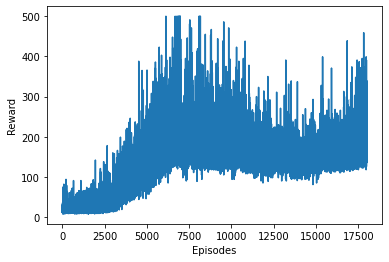

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

filename = 'Cartpole.png'
x = [i+1 for i in range(n_games)]

# plot_learning_curve(x,scores,eps_history,filename)

# x = [i+1 for i in range(n_games)]

# plotLearning(x,scores,eps_history,filename)
plt.plot(x, score_history)
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()
plt.savefig('saved_figure_AC.png')

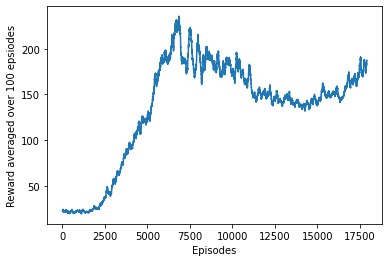

In [43]:
avg_score_history = []
i =0
x = [i+1 for i in range(n_games-100)]
i=0
for i in range(n_games-100):
    avg_score_history.append(np.mean(score_history[i:i+100]))
    
plt.plot(x, avg_score_history)
plt.xlabel("Episodes")
plt.ylabel("Reward averaged over 100 epsiodes")
# plt.xlim([1,18000])
plt.show()

#### Thoughts
* Why is the reward going down after a certain point
* How to overcome the dip in the reward? what if we use the saved model with best weights and start from there
* Change the critic loss to 'Huber loss' and perform the simulation